In [1]:
#!pip install kaggle 
#!pip install missingno
#!pip install scikit-image
#!pip install rapidfuzz

In [2]:

import requests
import pandas as pd
import os
import importlib
import utils

importlib.reload(utils)


import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import missingno as msno
from datetime import date

from skimage.feature import shape_index
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

from gmpy2 import random_state
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay, accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import os
import unicodedata
import difflib

import shutil

from pathlib import Path

import re
from rapidfuzz import process, fuzz
from concurrent.futures import ThreadPoolExecutor

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)


from kaggle.api.kaggle_api_extended import KaggleApi

In [3]:
#api = KaggleApi()
#api.authenticate()

#api.dataset_download_files('olistbr/brazilian-ecommerce', path='./dataset', unzip=True)

In [4]:
# Bu dosyanın (script) bulunduğu klasörü baz alıyoruz
base_path = os.path.join(os.getcwd(), "dataset")

file_name_customers = "olist_customers_dataset.csv"
file_name_geolocation = "olist_geolocation_dataset.csv"
file_name_orderitems = "olist_order_items_dataset.csv"
file_name_orderpayments = "olist_order_payments_dataset.csv"
file_name_orderreviews = "olist_order_reviews_dataset.csv"
file_name_orders = "olist_orders_dataset.csv"
file_name_products = "olist_products_dataset.csv"
file_name_sellers = "olist_sellers_dataset.csv"
file_name_category_name_translation = "product_category_name_translation.csv"


# Tam yol
customers_path = os.path.join(base_path, file_name_customers)
geolocation_path = os.path.join(base_path, file_name_geolocation)
orderitems_path = os.path.join(base_path, file_name_orderitems)
orderpayments_path = os.path.join(base_path, file_name_orderpayments)
orderreviews_path = os.path.join(base_path, file_name_orderreviews)
orders_path = os.path.join(base_path, file_name_orders)
products_path = os.path.join(base_path, file_name_products)
sellers_path = os.path.join(base_path, file_name_sellers)
product_category_name_translation_path = os.path.join(base_path, file_name_category_name_translation)

def load(dataset):
    try:
        data = pd.read_csv(dataset)
        return data
    except FileNotFoundError:
        print(f"Dosya bulunamadı: {dataset}")
        return None

In [5]:
df_customers = load(customers_path)
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [6]:
df_geo_avg = load(geolocation_path)
df_geo_avg.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.546,-46.639,sao paulo,SP
1,1046,-23.546,-46.645,sao paulo,SP
2,1046,-23.546,-46.643,sao paulo,SP
3,1041,-23.544,-46.639,sao paulo,SP
4,1035,-23.542,-46.642,sao paulo,SP


In [7]:
# zip prefix bazında özet tablo
summary = (
    df_geo_avg.groupby("geolocation_zip_code_prefix")
    .agg(
        city_count=("geolocation_city", "nunique"),     # kaç farklı şehir var
        state_count=("geolocation_state", "nunique"),   # kaç farklı eyalet var
        coord_count=("geolocation_lat", "count"),       # toplam satır sayısı (koordinat sayısı)
        lat_std=("geolocation_lat", "std"),             # enlem sapması
        lng_std=("geolocation_lng", "std")              # boylam sapması
    )
    .reset_index()
)

summary.head()


,geolocation_zip_code_prefix,city_count,state_count,coord_count,lat_std,lng_std
0,1001,2,1,26,0.001,0.000
1,1002,2,1,13,0.001,0.001
2,1003,2,1,17,0.000,0.001
3,1004,2,1,22,0.001,0.000
4,1005,2,1,25,0.000,0.001


In [8]:
# %95 eşiklerini hesapla
lat_thresh = summary['lat_std'].quantile(0.95)
lng_thresh = summary['lng_std'].quantile(0.95)

# geniş alan zip’leri seç
wide_zips = summary[
    (summary['lat_std'] > lat_thresh) |
    (summary['lng_std'] > lng_thresh)
]

print("Lat std için %95 eşik:", lat_thresh)
print("Lng std için %95 eşik:", lng_thresh)
print("Eşik üzerinde kaç kayıt var:", len(wide_zips))
wide_zips.head(10)



Lat std için %95 eşik: 0.04056525284991052
Lng std için %95 eşik: 0.045473794164270054
Eşik üzerinde kaç kayıt var: 1272


,geolocation_zip_code_prefix,city_count,state_count,coord_count,lat_std,lng_std
130,1239,2,1,152,0.012,0.066
202,1417,2,1,86,0.026,0.079
215,1430,2,1,11,0.145,0.013
216,1431,2,1,13,0.117,0.011
257,1513,1,1,24,0.023,0.072
406,2169,2,1,45,0.106,0.071
458,2237,1,1,8,0.136,0.045
508,2290,2,1,3,0.109,0.047
531,2323,2,1,56,0.044,0.053
532,2324,2,1,48,0.087,0.033


In [9]:
# summary tablosundan gerekli sütunları alıyoruz
zip_summary = summary[['geolocation_zip_code_prefix', 'city_count', 'state_count']].copy()

# Durum sütunu ekleyelim
def zip_type(row):
    if row['state_count'] > 1:
        return 'Farklı eyaletlerde'
    elif row['state_count'] == 1 and row['city_count'] > 1:
        return 'Aynı eyalette farklı şehirler'
    else:
        return 'Tek şehir, tek eyalet'

zip_summary['type'] = zip_summary.apply(zip_type, axis=1)

# Sıralama: önce eyalet sayısına göre, sonra şehir sayısına göre
zip_summary_sorted = zip_summary.sort_values(
    by=['state_count', 'city_count'], 
    ascending=[False, False]
).reset_index(drop=True)

# Örnek olarak ilk 20 satırı göster
zip_summary_sorted.head(20)

,geolocation_zip_code_prefix,city_count,state_count,type
0,72915,3,2,Farklı eyaletlerde
1,2116,2,2,Farklı eyaletlerde
2,4011,2,2,Farklı eyaletlerde
3,78557,2,2,Farklı eyaletlerde
4,80630,2,2,Farklı eyaletlerde
5,21550,1,2,Farklı eyaletlerde
6,23056,1,2,Farklı eyaletlerde
7,79750,1,2,Farklı eyaletlerde
8,6900,5,1,Aynı eyalette farklı şehirler
9,13318,5,1,Aynı eyalette farklı şehirler


In [10]:
# Aynı eyalette birden fazla şehir
same_state_multi_city = zip_summary_sorted[(zip_summary_sorted['state_count'] == 1) & (zip_summary_sorted['city_count'] > 1)]
same_state_multi_city_count = same_state_multi_city.shape[0]

# Farklı eyaletlerde olan zip kodları
multi_state = zip_summary_sorted[zip_summary_sorted['state_count'] > 1]
multi_state_count = multi_state.shape[0]

same_state_multi_city_count, multi_state_count


(8551, 8)

In [11]:
# Farklı eyaletleri kapsayan zip kodları
multi_state_zips = zip_summary_sorted[zip_summary_sorted['state_count'] > 1]

# İlk 10 satırı göster
multi_state_zips.head(10)

# İstersen tüm listeyi görmek için:
multi_state_zips


,geolocation_zip_code_prefix,city_count,state_count,type
0,72915,3,2,Farklı eyaletlerde
1,2116,2,2,Farklı eyaletlerde
2,4011,2,2,Farklı eyaletlerde
3,78557,2,2,Farklı eyaletlerde
4,80630,2,2,Farklı eyaletlerde
5,21550,1,2,Farklı eyaletlerde
6,23056,1,2,Farklı eyaletlerde
7,79750,1,2,Farklı eyaletlerde


In [12]:
# Farklı eyaletleri kapsayan zip kodları ve eyalet isimleri
state_counts = df_geo_avg.groupby('geolocation_zip_code_prefix')['geolocation_state'].nunique()
zip_diff_states = state_counts[state_counts > 1].reset_index()
zip_diff_states = zip_diff_states.merge(
    df_geo_avg.groupby('geolocation_zip_code_prefix')['geolocation_state'].unique().reset_index(),
    on='geolocation_zip_code_prefix'
)
zip_diff_states = zip_diff_states.rename(columns={'geolocation_state': 'states'})
zip_diff_states


,geolocation_zip_code_prefix,geolocation_state_x,geolocation_state_y
0,2116,2,"[SP, RN]"
1,4011,2,"[SP, AC]"
2,21550,2,"[RJ, AC]"
3,23056,2,"[RJ, AC]"
4,72915,2,"[GO, DF]"
5,78557,2,"[MT, RO]"
6,79750,2,"[MS, RS]"
7,80630,2,"[PR, SC]"


In [13]:
city_counts = df_geo_avg.groupby('geolocation_zip_code_prefix')['geolocation_city'].nunique()
zip_same_state_diff_city = city_counts[(city_counts > 1) & (df_geo_avg.groupby('geolocation_zip_code_prefix')['geolocation_state'].nunique() == 1)]
zip_same_state_diff_city = zip_same_state_diff_city.reset_index()
zip_same_state_diff_city = zip_same_state_diff_city.merge(
    df_geo_avg.groupby('geolocation_zip_code_prefix')['geolocation_city'].unique().reset_index(),
    on='geolocation_zip_code_prefix'
)
zip_same_state_diff_city = zip_same_state_diff_city.rename(columns={'geolocation_city': 'cities'})
zip_same_state_diff_city.head()

,geolocation_zip_code_prefix,geolocation_city_x,geolocation_city_y
0,1001,2,"[sao paulo, são paulo]"
1,1002,2,"[sao paulo, são paulo]"
2,1003,2,"[sao paulo, são paulo]"
3,1004,2,"[sao paulo, são paulo]"
4,1005,2,"[sao paulo, são paulo]"


In [14]:
# Her zip için state ve city bilgisi
zip_info = (
    df_geo_avg
    .groupby('geolocation_zip_code_prefix')
    .agg(
        state_count=('geolocation_state', 'nunique'),
        states=('geolocation_state', lambda x: list(x.unique())),
        max_city_count=('geolocation_city', lambda x: x.nunique())  # her zip içindeki toplam farklı şehir sayısı
    )
    .reset_index()
)

# Sıralama: önce state_count, sonra max_city_count
zip_info_sorted = zip_info.sort_values(
    by=['state_count', 'max_city_count'], 
    ascending=[False, False]
).reset_index(drop=True)

zip_info_sorted.head(20)



,geolocation_zip_code_prefix,state_count,states,max_city_count
0,72915,2,"[GO, DF]",3
1,2116,2,"[SP, RN]",2
2,4011,2,"[SP, AC]",2
3,78557,2,"[MT, RO]",2
4,80630,2,"[PR, SC]",2
5,21550,2,"[RJ, AC]",1
6,23056,2,"[RJ, AC]",1
7,79750,2,"[MS, RS]",1
8,6900,1,[SP],5
9,13318,1,[SP],5


In [15]:
df_orderitems = load(orderitems_path)
df_orderitems.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.900,13.290
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.900,19.930
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.000,17.870
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.990,12.790
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.900,18.140


In [16]:
df_orderpayments = load(orderpayments_path)
df_orderpayments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.330
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.390
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.710
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.780
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.450


In [17]:
df_orderreviews = load(orderreviews_path)
df_orderreviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [18]:
df_orders = load(orders_path)
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [19]:
df_products = load(products_path)
df_products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.000,287.000,1.000,225.000,16.000,10.000,14.000
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.000,276.000,1.000,1000.000,30.000,18.000,20.000
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.000,250.000,1.000,154.000,18.000,9.000,15.000
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.000,261.000,1.000,371.000,26.000,4.000,26.000
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.000,402.000,4.000,625.000,20.000,17.000,13.000


In [20]:
df_sellers = load(sellers_path)
df_sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


### Farkli yazim sekilleri nedeniyle tekrar eden ayni sehir ve eyaletlerin tespiti

In [21]:
# 1️⃣ Gelişmiş şehir normalizasyonu
def normalize_city_advanced(name: str) -> str:
    if pd.isna(name):
        return ""
    name = name.strip().lower()
    # Aksanları kaldır
    name = ''.join(c for c in unicodedata.normalize('NFD', name) if unicodedata.category(c) != 'Mn')
    # Nokta, tire, apostrof, boşluk gibi karakterleri kaldır
    name = re.sub(r'[\s\.\-\'"]', '', name)
    return name

In [22]:
# 2️⃣ Benzer şehirleri gruplayıp tekilleştirme
def deduplicate_cities(city_list, threshold: float = 0.9) -> dict:
    mapping = {}
    for i, city in enumerate(city_list):
        if city not in mapping:
            mapping[city] = city  # ilk gördüğünü referans al
        for other in city_list[i+1:]:
            similarity = difflib.SequenceMatcher(None, city, other).ratio()
            if similarity >= threshold:
                mapping[other] = mapping[city]
    return mapping

In [23]:
# 3. Eyalet bazında şehir eşleştirme (multithreading)
def deduplicate_state(row, state_col, threshold):
    state = row[state_col]
    city_list = list(row['cities'])
    mapping = deduplicate_names_rf(city_list, threshold)
    return {(state, k): v for k, v in mapping.items()}

In [24]:
# 4. Ana fonksiyon (şehir + eyalet)

def clean_city_names(df, city_col, state_col, similarity_threshold=0.9):
    """
    Tüm şehir isimlerini normalize eder ve benzer şehirleri tekilleştirir.
    """
    # Normalize edilmiş şehir sütunu
    df['city_norm'] = df[city_col].apply(normalize_city_advanced)

    # Eyalet bazında şehir listesi
    state_cities = (
        df.groupby(state_col)['city_norm']
        .unique()
        .reset_index()
        .rename(columns={'city_norm': 'cities'})
    )

    # Eyalet bazlı eşleşmeler
    all_mappings = {}
    for idx, row in state_cities.iterrows():
        state = row[state_col]
        city_list = list(row['cities'])
        mapping = deduplicate_cities(city_list, threshold=similarity_threshold)
        for raw_city, clean_city in mapping.items():
            all_mappings[(state, raw_city)] = clean_city

    # Orijinal tabloyu güncelle
    df[city_col] = df.apply(
        lambda row: all_mappings.get((row[state_col], row['city_norm']), row['city_norm']),
        axis=1
    )

    # Geçici sütunu kaldır
    df = df.drop(columns=['city_norm'])
    
    return df

In [25]:
# geolocation tablosu için
df_geo_avg = clean_city_names(df_geo_avg, city_col='geolocation_city', state_col='geolocation_state')

In [26]:
# Customers tablosu için
df_customers = clean_city_names(df_customers, city_col='customer_city', state_col='customer_state')


In [27]:
# Sellers tablosu için
df_sellers = clean_city_names(df_sellers, city_col='seller_city', state_col='seller_state')

## Temizleme işleminden sonra hala tekrar eden şehir isimleri kaldı mı kontrol

In [28]:
def check_remaining_similar_cities(df, city_col, state_col, threshold=0.9):
    """
    Temizlenmiş tabloda hala birbirine benzer şehir var mı diye kontrol eder.
    """
    state_cities = (
        df.groupby(state_col)[city_col]
        .unique()
        .reset_index()
        .rename(columns={city_col: 'cities'})
    )

    all_duplicates = {}
    for _, row in state_cities.iterrows():
        state = row[state_col]
        cities = row['cities']
        duplicates = []
        for i, city in enumerate(cities):
            for other in cities[i+1:]:
                similarity = difflib.SequenceMatcher(None, city, other).ratio()
                if similarity >= threshold:
                    duplicates.append((city, other, similarity))
        if duplicates:
            all_duplicates[state] = duplicates

    if not all_duplicates:
        print("✅ Hiç tekrar eden veya benzer şehir kalmadı.")
    else:
        for state, duplicates in all_duplicates.items():
            print(f"\nEyalet: {state}")
            for dup in duplicates:
                print(f" - {dup[0]} ~ {dup[1]} (benzerlik: {dup[2]:.2f})")



In [29]:
check_remaining_similar_cities(df_geo_avg, city_col='geolocation_city', state_col='geolocation_state' )

✅ Hiç tekrar eden veya benzer şehir kalmadı.


In [30]:
check_remaining_similar_cities(df_sellers, city_col='seller_city', state_col='seller_state' )

✅ Hiç tekrar eden veya benzer şehir kalmadı.


In [31]:
check_remaining_similar_cities(df_customers, city_col='customer_city', state_col='customer_state' )

✅ Hiç tekrar eden veya benzer şehir kalmadı.


# DATA MODELING

-----------------------------
️1-  Basit sayısal ID oluşturma fonksiyonu
-----------------------------

In [32]:
# Prefiksli ID oluşturma (ID olan tablolar)
def create_prefixed_id(df, original_id_col, new_id_col, prefix):
    df = df.copy()
    id_map = {old_id: f"{prefix}{str(i+1).zfill(3)}" for i, old_id in enumerate(df[original_id_col])}
    df[new_id_col] = df[original_id_col].map(id_map)
    return df, id_map

# Prefiksli ID oluşturma (ID olmayan tablolar)
def create_prefixed_id_no_col(df, new_id_col, prefix):
    df = df.copy()
    df[new_id_col] = [f"{prefix}{str(i+1).zfill(3)}" for i in range(len(df))]
    return df


️2- PK’ları Prefiksli ID’ye Çevirme ve Mapping Saklama
-----------------------------


In [33]:

# Sellers
df_sellers, seller_id_map = create_prefixed_id(df_sellers, "seller_id", "seller_id_pref", "SEL")

# Orders
df_orders, order_id_map = create_prefixed_id(df_orders, "order_id", "order_id_pref", "ORD")

# Products
df_products, product_id_map = create_prefixed_id(df_products, "product_id", "product_id_pref", "PRO")

# Customers
df_customers, customers_id_map = create_prefixed_id(df_customers, "customer_id", "customer_id_pref", "CUS")


# Order Items (ID olmayan ama ürün sayısı kolonu korunacak)
df_orderitems = df_orderitems.rename(columns={"order_item_id": "order_item_number"})  # PK değil
df_orderitems = create_prefixed_id_no_col(df_orderitems, "order_item_pref", "OIT")
# Order Payments
df_orderpayments= create_prefixed_id_no_col(df_orderpayments, "orderpayment_id_pref", "PAY")
# Geolocation (ID yok)
df_geo_avg = create_prefixed_id_no_col(df_geo_avg, "geolocation_id_pref", "GEO")


In [34]:
# Orders → customer_id_pref ekle
df_orders["customer_id_pref"] = df_orders["customer_id"].map(customers_id_map)

# Order Items → order_id_pref, product_id_pref, seller_id_pref ekle
df_orderitems["order_id_pref"] = df_orderitems["order_id"].map(order_id_map)
df_orderitems["product_id_pref"] = df_orderitems["product_id"].map(product_id_map)
df_orderitems["seller_id_pref"] = df_orderitems["seller_id"].map(seller_id_map)

# Order Payments → order_id_pref ekle
df_orderpayments["order_id_pref"] = df_orderpayments["order_id"].map(order_id_map)


In [35]:
# 1. Eşsiz customer_unique_id listesi
unique_customers = df_customers[['customer_unique_id']].drop_duplicates().reset_index(drop=True)

# 2. Yeni ID oluştur
unique_customers['cusUni'] = [f"CUSUNI{str(i+1).zfill(4)}" for i in range(len(unique_customers))]

# 3. Orijinal tabloya merge ile ekle
df_customers = df_customers.merge(unique_customers, on='customer_unique_id', how='left')


In [36]:
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_id_pref,cusUni
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,CUS001,CUSUNI0001
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,saobernardodocampo,SP,CUS002,CUSUNI0002
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,saopaulo,SP,CUS003,CUSUNI0003
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogidascruzes,SP,CUS004,CUSUNI0004
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,CUS005,CUSUNI0005


In [37]:
# 1. Her customer_unique_id kaç farklı cusUni ile eşleşmiş 
check_unique = df_customers.groupby('customer_unique_id')['cusUni'].nunique().reset_index()
check_unique.rename(columns={'cusUni': 'num_unique_ids'}, inplace=True)

# 2. Eğer her customer_unique_id yalnızca bir cusUni ile eşleşmişse tamamdır
problem_customers = check_unique[check_unique['num_unique_ids'] != 1]

if problem_customers.empty:
    print("Tüm müşteri unique ID’leri düzgün şekilde tek bir yeni ID ile eşleşmiş.")
else:
    print("Dikkat! Bazı müşteri unique ID’leri birden fazla yeni ID ile eşleşmiş:")
    print(problem_customers)



Tüm müşteri unique ID’leri düzgün şekilde tek bir yeni ID ile eşleşmiş.


In [38]:
customer_id = "1b6c7548a2a1f9037c1fd3ddfed95f33"

customer_info = df_customers[df_customers['customer_unique_id'] == customer_id]

customer_info


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_id_pref,cusUni
7012,53e16f83735cfe02bf83ef6481ca241e,1b6c7548a2a1f9037c1fd3ddfed95f33,38301,ituiutaba,MG,CUS7013,CUSUNI6996
12164,95b9cacc4bc81c3a0a33967bcde6fcd8,1b6c7548a2a1f9037c1fd3ddfed95f33,38301,ituiutaba,MG,CUS12165,CUSUNI6996
16824,41a16488effb86580d7a89f8aa19a03b,1b6c7548a2a1f9037c1fd3ddfed95f33,38301,ituiutaba,MG,CUS16825,CUSUNI6996
24987,fff7466a253c0e59499ea943462c10f9,1b6c7548a2a1f9037c1fd3ddfed95f33,38301,ituiutaba,MG,CUS24988,CUSUNI6996
50663,c2ff01bd4fa72f9487ee397f6c5989d2,1b6c7548a2a1f9037c1fd3ddfed95f33,38301,ituiutaba,MG,CUS50664,CUSUNI6996
65287,9a4578c9dd9dce6517d583cb5eca0276,1b6c7548a2a1f9037c1fd3ddfed95f33,38301,ituiutaba,MG,CUS65288,CUSUNI6996
66714,ee5c2e36a79081c2440e61990ec2f3af,1b6c7548a2a1f9037c1fd3ddfed95f33,38301,ituiutaba,MG,CUS66715,CUSUNI6996


Customers ve Sellers  tablosuna geolocation_id_pref ekle

Artık zip code ve city/state kolonlarını customers & sellers'tan silebiliriz

Orijinal ID’leri sil

In [39]:
# Orijinal ID kolonları
drop_cols = {
    "customers": ["customer_id", "customer_unique_id"],
    "sellers": ["seller_id", "unique_id"],
    "orders": ["order_id", "customer_id", "unique_id"],
    "order_items": ["order_id", "product_id", "seller_id", "unique_id"],
    "products": ["product_id", "unique_id"],
    "order_payments": ["orderpayment_id", "order_id", "unique_id"],
    "df_geo_avg": ["unique_id"]
}

dfs = {
    "customers": df_customers,
    "sellers": df_sellers,
    "orders": df_orders,
    "order_items": df_orderitems,
    "products": df_products,
    "order_payments": df_orderpayments,
    "df_geo_avg": df_geo_avg
}

for name, df in dfs.items():
    cols_to_drop = [c for c in drop_cols[name] if c in df.columns]
    dfs[name] = df.drop(columns=cols_to_drop)

(df_customers, df_sellers, df_orders, df_orderitems,
 df_products, df_orderpayments, df_geo_avg) = [dfs[k] for k in dfs]
  

Prefiksli ID’leri başa taşı

In [40]:
def move_prefixed_id_first(df, prefixed_id_col, fk_cols=[]):
    df = df.copy()
    cols = [prefixed_id_col] + fk_cols + [c for c in df.columns if c not in ([prefixed_id_col] + fk_cols)]
    return df[cols]

# Başta prefiksli ID, FK’lar da başa
df_customers = move_prefixed_id_first(df_customers, "customer_id_pref")
df_sellers = move_prefixed_id_first(df_sellers, "seller_id_pref")
df_orders = move_prefixed_id_first(df_orders, "order_id_pref", fk_cols=["customer_id_pref"])
df_orderitems = move_prefixed_id_first(df_orderitems, "order_item_pref", fk_cols=["order_id_pref", "product_id_pref", "seller_id_pref"])
df_products = move_prefixed_id_first(df_products, "product_id_pref")
df_orderpayments = move_prefixed_id_first(df_orderpayments, "orderpayment_id_pref", fk_cols=["order_id_pref"])
df_geo_avg = move_prefixed_id_first(df_geo_avg, "geolocation_id_pref")


In [41]:
df_geo_avg.head()

,geolocation_id_pref,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,GEO001,1037,-23.546,-46.639,saopaulo,SP
1,GEO002,1046,-23.546,-46.645,saopaulo,SP
2,GEO003,1046,-23.546,-46.643,saopaulo,SP
3,GEO004,1041,-23.544,-46.639,saopaulo,SP
4,GEO005,1035,-23.542,-46.642,saopaulo,SP


In [42]:
df_geolocation = df_geo_avg

In [43]:

# 1. GEO tablosundan ortalama koordinat çıkar (geo_avg)
df_geo_avg = (
    df_geolocation
    .groupby("geolocation_zip_code_prefix")[["geolocation_lat", "geolocation_lng"]]
    .mean()
    .reset_index()
    .rename(columns={
        "geolocation_zip_code_prefix": "zip_prefix",
        "geolocation_lat": "lat_avg",
        "geolocation_lng": "lng_avg"
    })
)

# 2. CUSTOMERS tablosuna ortalama koordinat ekle
df_customers = df_customers.merge(
    df_geo_avg,
    left_on="customer_zip_code_prefix",
    right_on="zip_prefix",
    how="left"
).drop(columns=["zip_prefix"])  # temp kolon gerekmez

# 3. SELLERS tablosuna ortalama koordinat ekle
df_sellers = df_sellers.merge(
    df_geo_avg,
    left_on="seller_zip_code_prefix",
    right_on="zip_prefix",
    how="left"
).drop(columns=["zip_prefix"])

# Artık:
# df_geo_full  -> ham geo data (zip + lat + lng + pk)
# geo_avg      -> zip bazlı ortalama koordinatlar
# df_customers -> müşteri tablosu + ortalama koordinatlar
# df_sellers   -> satıcı tablosu + ortalama koordinatlar


In [44]:
df_geo_avg.head()

,zip_prefix,lat_avg,lng_avg
0,1001,-23.550,-46.634
1,1002,-23.548,-46.635
2,1003,-23.549,-46.636
3,1004,-23.550,-46.635
4,1005,-23.549,-46.637


In [45]:
df_customers = df_customers.rename(columns={"customer_id_pref": "customer_order_id"})

In [46]:
df_customers = df_customers.rename(columns={
    'lat_avg': 'customer_lat_avg',
    'lng_avg': 'customer_lng_avg'
})

In [47]:
df_customers.head()

,customer_order_id,customer_zip_code_prefix,customer_city,customer_state,cusUni,customer_lat_avg,customer_lng_avg
0,CUS001,14409,franca,SP,CUSUNI0001,-20.498,-47.397
1,CUS002,9790,saobernardodocampo,SP,CUSUNI0002,-23.728,-46.543
2,CUS003,1151,saopaulo,SP,CUSUNI0003,-23.532,-46.656
3,CUS004,8775,mogidascruzes,SP,CUSUNI0004,-23.500,-46.185
4,CUS005,13056,campinas,SP,CUSUNI0005,-22.975,-47.143


In [48]:
df_geolocation.head()

,geolocation_id_pref,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,GEO001,1037,-23.546,-46.639,saopaulo,SP
1,GEO002,1046,-23.546,-46.645,saopaulo,SP
2,GEO003,1046,-23.546,-46.643,saopaulo,SP
3,GEO004,1041,-23.544,-46.639,saopaulo,SP
4,GEO005,1035,-23.542,-46.642,saopaulo,SP


In [49]:
df_orderitems.head()

,order_item_pref,order_id_pref,product_id_pref,seller_id_pref,order_item_number,shipping_limit_date,price,freight_value
0,OIT001,ORD85268,PRO25866,SEL514,1,2017-09-19 09:45:35,58.900,13.290
1,OIT002,ORD71854,PRO27231,SEL472,1,2017-05-03 11:05:13,239.900,19.930
2,OIT003,ORD6299,PRO22625,SEL1825,1,2018-01-18 14:48:30,199.000,17.870
3,OIT004,ORD22551,PRO15404,SEL2024,1,2018-08-15 10:10:18,12.990,12.790
4,OIT005,ORD5248,PRO8863,SEL1598,1,2017-02-13 13:57:51,199.900,18.140


In [50]:
df_sellers = df_sellers.rename(columns={
    'lat_avg': 'seller_lat_avg',
    'lng_avg': 'seller_lng_avg'
})

In [51]:
df_sellers.head()

,seller_id_pref,seller_zip_code_prefix,seller_city,seller_state,seller_lat_avg,seller_lng_avg
0,SEL001,13023,campinas,SP,-22.894,-47.061
1,SEL002,13844,mogiguacu,SP,-22.383,-46.948
2,SEL003,20031,riodejaneiro,RJ,-22.910,-43.178
3,SEL004,4195,saopaulo,SP,-23.657,-46.613
4,SEL005,12914,bragancapaulista,SP,-22.965,-46.534


In [52]:
df_orders = df_orders.rename(columns={"customer_id_pref": "customer_order_id"})
df_orders.head()

,order_id_pref,customer_order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,ORD001,CUS70297,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,ORD002,CUS77028,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,ORD003,CUS555,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,ORD004,CUS61082,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ORD005,CUS67264,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [53]:
df_orderitems.head()

,order_item_pref,order_id_pref,product_id_pref,seller_id_pref,order_item_number,shipping_limit_date,price,freight_value
0,OIT001,ORD85268,PRO25866,SEL514,1,2017-09-19 09:45:35,58.900,13.290
1,OIT002,ORD71854,PRO27231,SEL472,1,2017-05-03 11:05:13,239.900,19.930
2,OIT003,ORD6299,PRO22625,SEL1825,1,2018-01-18 14:48:30,199.000,17.870
3,OIT004,ORD22551,PRO15404,SEL2024,1,2018-08-15 10:10:18,12.990,12.790
4,OIT005,ORD5248,PRO8863,SEL1598,1,2017-02-13 13:57:51,199.900,18.140


In [54]:
df_products.head()

,product_id_pref,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,PRO001,perfumaria,40.000,287.000,1.000,225.000,16.000,10.000,14.000
1,PRO002,artes,44.000,276.000,1.000,1000.000,30.000,18.000,20.000
2,PRO003,esporte_lazer,46.000,250.000,1.000,154.000,18.000,9.000,15.000
3,PRO004,bebes,27.000,261.000,1.000,371.000,26.000,4.000,26.000
4,PRO005,utilidades_domesticas,37.000,402.000,4.000,625.000,20.000,17.000,13.000


In [55]:
df_orderpayments.head() 

,orderpayment_id_pref,order_id_pref,payment_sequential,payment_type,payment_installments,payment_value
0,PAY001,ORD75269,1,credit_card,8,99.330
1,PAY002,ORD98161,1,credit_card,1,24.390
2,PAY003,ORD43930,1,credit_card,1,65.710
3,PAY004,ORD64933,1,credit_card,8,107.780
4,PAY005,ORD12703,1,credit_card,2,128.450


### Data tablolari yeni klasore (cleaned_data_with_prefix_id) eklenmis durumda.
### Kodu yeniden calistirirsaniz ikinci bir data klasoru olusturulmaz ve 
### Bu klasor eger olusturulmus durumda ise tablolar bu klasore olustururlur.
### Mevcut tablolar onceden var ise , guncellenir. 
### Klasor yok ise bastan olusturulur...

In [56]:
# Kaydedilecek klasör adı
prefix_id_path = Path.cwd() / "cleaned_data_with_prefix_id"

# Her çalıştırmada klasörü sıfırla (varsa sil, sonra yeniden oluştur)
if prefix_id_path.exists():
    shutil.rmtree(prefix_id_path)
prefix_id_path.mkdir(parents=True, exist_ok=True)

# Kaydedilecek DataFrame'ler
dfs = {
    "customers": df_customers,
    "sellers": df_sellers,
    "orders": df_orders,
    "order_items": df_orderitems,
    "products": df_products,
    "order_payments": df_orderpayments,
    "geo_avg": df_geo_avg,
    "geolocation": df_geolocation,
}

# CSV olarak yaz
for name, df in dfs.items():
    file_path = prefix_id_path / f"{name}.csv"
    df.to_csv(file_path, index=False)
    print(f"{file_path} kaydedildi. shape={df.shape}")

D:\EuroTech_DataScience\Proje\cleaned_data_with_prefix_id\customers.csv kaydedildi. shape=(99441, 7)
D:\EuroTech_DataScience\Proje\cleaned_data_with_prefix_id\sellers.csv kaydedildi. shape=(3095, 6)
D:\EuroTech_DataScience\Proje\cleaned_data_with_prefix_id\orders.csv kaydedildi. shape=(99441, 8)
D:\EuroTech_DataScience\Proje\cleaned_data_with_prefix_id\order_items.csv kaydedildi. shape=(112650, 8)
D:\EuroTech_DataScience\Proje\cleaned_data_with_prefix_id\products.csv kaydedildi. shape=(32951, 9)
D:\EuroTech_DataScience\Proje\cleaned_data_with_prefix_id\order_payments.csv kaydedildi. shape=(103886, 6)
D:\EuroTech_DataScience\Proje\cleaned_data_with_prefix_id\geo_avg.csv kaydedildi. shape=(19015, 3)
D:\EuroTech_DataScience\Proje\cleaned_data_with_prefix_id\geolocation.csv kaydedildi. shape=(1000163, 6)


### Yeni Olusturulan Dosya Yollari
#### notebook yeniden baslatildiginda direk buradan tablolar yuklenebilir..

In [57]:
# Bu dosyanın (script) bulunduğu klasörü baz alıyoruz
base_path = os.path.join(os.getcwd(), "cleaned_data_with_prefix_id")

new_file_name_customers = "customers.csv"
new_file_name_geolocation = "geolocation.csv"
new_file_name_geo_avg = "geo_avg.csv"
new_file_name_orderitems = "order_items.csv"
new_file_name_orderpayments = "order_payments.csv"
new_file_name_orders = "orders.csv"
new_file_name_products = "products.csv"
new_file_name_sellers = "sellers.csv"

# Tam yol
new_customers_path = os.path.join(base_path, new_file_name_customers)
new_geolocation_path = os.path.join(base_path, new_file_name_geolocation)
new_geo_avg_path = os.path.join(base_path, new_file_name_geo_avg)
new_orderitems_path = os.path.join(base_path, new_file_name_orderitems)
new_orderpayments_path = os.path.join(base_path, new_file_name_orderpayments)
new_orders_path = os.path.join(base_path, new_file_name_orders)
new_products_path = os.path.join(base_path, new_file_name_products)
new_sellers_path = os.path.join(base_path, new_file_name_sellers)



In [58]:
def load(dataset):
    try:
        data = pd.read_csv(dataset)
        return data
    except FileNotFoundError:
        print(f"Dosya bulunamadı: {dataset}")
        return None

In [59]:
df_customers = load(new_customers_path)

df_customers.head()

,customer_order_id,customer_zip_code_prefix,customer_city,customer_state,cusUni,customer_lat_avg,customer_lng_avg
0,CUS001,14409,franca,SP,CUSUNI0001,-20.498,-47.397
1,CUS002,9790,saobernardodocampo,SP,CUSUNI0002,-23.728,-46.543
2,CUS003,1151,saopaulo,SP,CUSUNI0003,-23.532,-46.656
3,CUS004,8775,mogidascruzes,SP,CUSUNI0004,-23.500,-46.185
4,CUS005,13056,campinas,SP,CUSUNI0005,-22.975,-47.143


In [60]:
df_geolocation = load(new_geolocation_path)
df_geolocation.head()

,geolocation_id_pref,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,GEO001,1037,-23.546,-46.639,saopaulo,SP
1,GEO002,1046,-23.546,-46.645,saopaulo,SP
2,GEO003,1046,-23.546,-46.643,saopaulo,SP
3,GEO004,1041,-23.544,-46.639,saopaulo,SP
4,GEO005,1035,-23.542,-46.642,saopaulo,SP


In [61]:
df_orderitems = load(new_orderitems_path)
df_orderitems.head()

,order_item_pref,order_id_pref,product_id_pref,seller_id_pref,order_item_number,shipping_limit_date,price,freight_value
0,OIT001,ORD85268,PRO25866,SEL514,1,2017-09-19 09:45:35,58.900,13.290
1,OIT002,ORD71854,PRO27231,SEL472,1,2017-05-03 11:05:13,239.900,19.930
2,OIT003,ORD6299,PRO22625,SEL1825,1,2018-01-18 14:48:30,199.000,17.870
3,OIT004,ORD22551,PRO15404,SEL2024,1,2018-08-15 10:10:18,12.990,12.790
4,OIT005,ORD5248,PRO8863,SEL1598,1,2017-02-13 13:57:51,199.900,18.140


In [62]:
df_orderpayments = load(new_orderpayments_path)
df_orderpayments.head()

,orderpayment_id_pref,order_id_pref,payment_sequential,payment_type,payment_installments,payment_value
0,PAY001,ORD75269,1,credit_card,8,99.330
1,PAY002,ORD98161,1,credit_card,1,24.390
2,PAY003,ORD43930,1,credit_card,1,65.710
3,PAY004,ORD64933,1,credit_card,8,107.780
4,PAY005,ORD12703,1,credit_card,2,128.450


In [63]:
df_orders = load(new_orders_path)
df_orders.head()

,order_id_pref,customer_order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,ORD001,CUS70297,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,ORD002,CUS77028,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,ORD003,CUS555,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,ORD004,CUS61082,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ORD005,CUS67264,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [64]:
df_products = load(new_products_path)
df_products.head()

,product_id_pref,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,PRO001,perfumaria,40.000,287.000,1.000,225.000,16.000,10.000,14.000
1,PRO002,artes,44.000,276.000,1.000,1000.000,30.000,18.000,20.000
2,PRO003,esporte_lazer,46.000,250.000,1.000,154.000,18.000,9.000,15.000
3,PRO004,bebes,27.000,261.000,1.000,371.000,26.000,4.000,26.000
4,PRO005,utilidades_domesticas,37.000,402.000,4.000,625.000,20.000,17.000,13.000


In [65]:
df_sellers = load(new_sellers_path)

df_sellers.head()

,seller_id_pref,seller_zip_code_prefix,seller_city,seller_state,seller_lat_avg,seller_lng_avg
0,SEL001,13023,campinas,SP,-22.894,-47.061
1,SEL002,13844,mogiguacu,SP,-22.383,-46.948
2,SEL003,20031,riodejaneiro,RJ,-22.910,-43.178
3,SEL004,4195,saopaulo,SP,-23.657,-46.613
4,SEL005,12914,bragancapaulista,SP,-22.965,-46.534


## Mevcut dimension tablolarını kullanarak `fact_order_shipments` tablosu

Payments kısmında bazı siparişler için birden fazla ödeme yöntemi kullanılması ve taksitli şekilde ödeme gerçekleşmesi sebebiyle ödemelerde ayı sipariş iöin birden fazla satır bulunuyor. Her bir siparişi tek satır halinde yazmak için `pay_agg` isimli bir dataframe oluşturup aggrigasyon işlemlerini yapıyorum:


Burada aynı sipariş üzerinde birden fazla ödeme şekli varsa onları bir satıra (`payment_types`) aralarına `/` işareti koyarak ayırıyorum. Taksitli satış ödemelerinin taksit sayısının en yükseğini alarak olası taksit sayısı sorgulamalarında kullanılmak üzere dataframe üzerinde bırakıyorum (`payment_installment_max`) ve son olarak ödenen tutarı toplayarak (`payment_value_sum`) her bir sipariş tutarı için bir toplam ödeme satırı oluşturmuş oluyorum. 

In [66]:
multi_pay_orders = (
    df_orderpayments
      .groupby("order_id_pref")
      .filter(lambda x: len(x) > 1)   # aynı Şiparişte olup satır sayısı >1 olanlar
      .sort_values(["order_id_pref","payment_sequential"])
)

print("Birden fazla payment kaydı olan sipariş sayısı:",
      multi_pay_orders["order_id_pref"].nunique())

# Örnek olarak ilk 10 siparişi göster
multi_pay_orders.head(20)

Birden fazla payment kaydı olan sipariş sayısı: 2961


,orderpayment_id_pref,order_id_pref,payment_sequential,payment_type,payment_installments,payment_value
10770,PAY10771,ORD001,1,credit_card,1,18.120
91130,PAY91131,ORD001,2,voucher,1,18.590
44246,PAY44247,ORD001,3,voucher,1,2.000
52200,PAY52201,ORD010,1,credit_card,1,8.340
16545,PAY16546,ORD010,2,voucher,1,161.420
92279,PAY92280,ORD020,1,credit_card,1,5.960
35461,PAY35462,ORD020,2,voucher,1,62.150
42035,PAY42036,ORD020,3,voucher,1,24.860
76131,PAY76132,ORD078,1,credit_card,1,7.080
44840,PAY44841,ORD078,2,voucher,1,227.200


In [67]:
# --- PAY_AGG: sipariş bazında ödeme özetleri ---
pay_agg = (df_orderpayments
           .groupby("order_id_pref", as_index=False)
           .agg(
               payment_value_sum=("payment_value", "sum"), # bir siparişe yapılan toplam ödemeyi bir satıra koy
               payment_installments_max=("payment_installments", "max"), # Taksit sayısının en yükseğini sakla
               payment_types=("payment_type", lambda s: "/".join(sorted(s.astype(str).unique()))) #ödeme şekillerini / ile aynı satıra yaz
           ))

# Çoklu ödeme satırı olan siparişleri bul (önceki adımın kısa hali)
multi_idler = (df_orderpayments.groupby("order_id_pref")
             .size().loc[lambda s: s > 1].index)

# Sadece bu siparişlerin pay_agg görünümü
pay_agg_multi = (pay_agg[pay_agg["order_id_pref"].isin(multi_idler)]
                 .sort_values("order_id_pref"))

print("Çoklu ödeme satırı olan sipariş sayısı:", len(multi_idler))
pay_agg_multi.head(20)

Çoklu ödeme satırı olan sipariş sayısı: 2961


,order_id_pref,payment_value_sum,payment_installments_max,payment_types
0,ORD001,38.710,1,credit_card/voucher
9,ORD010,169.760,1,credit_card/voucher
19,ORD020,92.970,1,credit_card/voucher
77,ORD078,234.280,1,credit_card/voucher
98,ORD099,28.860,1,credit_card/voucher
158,ORD10052,212.810,5,credit_card/voucher
243,ORD10129,182.360,5,credit_card/voucher
286,ORD10168,144.750,1,credit_card/voucher
287,ORD10169,126.300,1,credit_card/voucher
319,ORD10198,336.920,8,credit_card


Satır multiplikasyanu sıkıntısını çözdüğümüze göre `fact_df` adında, tüm dataframeleri birleştirdiğimiz bir dataframe oluşturabliriz. bunun için merge işlemini kullanacağım. 

In [68]:
fact_DF = (
    df_orderitems
      .merge(df_orders, on="order_id_pref", how="left")
      .merge(df_customers, on="customer_order_id", how="left")
      .merge(df_sellers, on="seller_id_pref", how="left")
      .merge(df_products, on="product_id_pref", how="left")
      .merge(pay_agg, on="order_id_pref", how="left") 
      )

In [69]:
fact_DF.shape

(112650, 37)

In [70]:
#  Tarih kolonlarını datetime tipine çevir
date_cols = [
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date',
    "order_purchase_timestamp"
]

for col in date_cols:
    fact_DF[col] = pd.to_datetime(fact_DF[col], errors='coerce')  # Hatalı tarihleri NaT yapar


In [71]:
#  Hazırlık ve teslim sürelerini hesapla
fact_DF["prep_time"] = (
    fact_DF["order_delivered_carrier_date"] - fact_DF["order_approved_at"]
).dt.days

fact_DF["shipping_time"] = (
    fact_DF["order_delivered_customer_date"] - fact_DF["order_delivered_carrier_date"]
).dt.days

fact_DF["estimated_time"] = (
    fact_DF["order_estimated_delivery_date"] - fact_DF["order_approved_at"]
).dt.days

In [72]:
# Null değer kontrolü p
print(fact_DF[['prep_time', 'shipping_time', 'estimated_time']].isnull().sum())

prep_time         1209
shipping_time     2455
estimated_time      15
dtype: int64


In [73]:
print(fact_DF.shape[0])
fact_DF[['prep_time', 'shipping_time', 'estimated_time']].isnull().mean() * 100


112650


prep_time        1.073
shipping_time    2.179
estimated_time   0.013
dtype: float64

In [74]:
#  Gecikme hesaplaması
fact_DF['delay_days'] = (fact_DF['order_delivered_customer_date'] - fact_DF['order_estimated_delivery_date']).dt.days
fact_DF['delay_days'] = fact_DF['delay_days'].apply(lambda x: max(0, x))
fact_DF['is_late'] = fact_DF['delay_days'].apply(lambda x: 1 if x > 0 else 0)


In [75]:
#  Gecikme sınıfı
def classify_delay(days):
    if days == 0:
        return 0
    elif 1 <= days <= 3:
        return 1
    elif 4 <= days <= 7:
        return 2
    elif 8 <= days <= 10:
        return 3
    else:
        return 4

fact_DF['delay_class'] = fact_DF['delay_days'].apply(classify_delay)

Gecikme sınıfı alternatif kod 


bins = [-1, 0, 3, 7, 10, float("inf")]
labels = [0, 1, 2, 3, 4]

fact_DF["delay_class"] = pd.cut(fact_DF["delay_days"], bins=bins, labels=labels).astype(int)

In [76]:
#  Müşteri-satıcı mesafesi
#!pip install haversine

from haversine import haversine, Unit
# haversine, genellikle iki koordinat arasındaki mesafeyi (km veya mil cinsinden) hesaplamak için kullanılır.

def compute_distance(row):
    return haversine((row['customer_lat_avg'], row['customer_lng_avg']), 
                     (row['seller_lat_avg'], row['seller_lng_avg']))

fact_DF['distance_km'] = fact_DF.apply(compute_distance, axis=1)

In [77]:
#  Aynı siparişteki satıcı sayısı
seller_count = df_orderitems.groupby('order_id_pref')['seller_id_pref'].nunique().reset_index()
seller_count.rename(columns={'seller_id_pref': 'seller_count_per_order'}, inplace=True)
fact_DF = fact_DF.merge(seller_count, on='order_id_pref', how='left')

In [78]:
#  İlgili sütunları seçerek final fact tablosu
fact_order_shipments = fact_DF[[
    'cusUni','customer_order_id', 'order_id_pref', 'seller_id_pref', 'product_id_pref', 
    'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
    'order_delivered_customer_date', 'order_estimated_delivery_date',
    'prep_time', 'shipping_time', 'estimated_time',
    'delay_days', 'delay_class', 'is_late', 'distance_km',
    'payment_types', 'payment_value_sum', 'payment_installments_max',
    'seller_count_per_order'
]]

In [79]:
fact_order_shipments.head()

,cusUni,customer_order_id,order_id_pref,seller_id_pref,product_id_pref,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,prep_time,shipping_time,estimated_time,delay_days,delay_class,is_late,distance_km,payment_types,payment_value_sum,payment_installments_max,seller_count_per_order
0,CUSUNI64073,CUS65558,ORD85268,SEL514,PRO25866,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,6.000,1.000,15.000,0.000,0,0,301.505,credit_card,72.190,2.000,1
1,CUSUNI33838,CUS34266,ORD71854,SEL472,PRO27231,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,8.000,8.000,18.000,0.000,0,0,585.565,credit_card,259.830,3.000,1
2,CUSUNI34511,CUS34956,ORD6299,SEL1825,PRO22625,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,1.000,6.000,21.000,0.000,0,0,312.344,credit_card,216.870,5.000,1
3,CUSUNI50803,CUS51764,ORD22551,SEL2024,PRO15404,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,2.000,4.000,11.000,0.000,0,0,293.169,credit_card,25.780,2.000,1
4,CUSUNI7582,CUS7603,ORD5248,SEL1598,PRO8863,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,11.000,13.000,40.000,0.000,0,0,646.164,credit_card,218.040,3.000,1


In [80]:


#fact_order_shipments.to_csv('fact_order_shipments.csv', index=False) # csv olarak kaydet. 

In [81]:
#fact_order_shipments.columns.to_list()

In [82]:
total_rows = fact_order_shipments.shape[0]

print(f"Toplam satır sayısı: {total_rows:,}\n")

# --- Negatif süreler ---
neg_counts = fact_order_shipments[["prep_time","shipping_time","estimated_time"]].lt(0).sum()
neg_perc   = (neg_counts / total_rows * 100).round(2)
print("Negatif süreler (adet ve %):")
for col in neg_counts.index:
    print(f"  {col:<15}: {neg_counts[col]}  ({neg_perc[col]}%)")

# --- Null oranları ---
null_counts = fact_order_shipments[["prep_time","shipping_time","estimated_time","delay_days","distance_km"]].isnull().sum()
null_perc   = (null_counts / total_rows * 100).round(2)
print("\nNull değerler (adet ve %):")
for col in null_counts.index:
    print(f"  {col:<15}: {null_counts[col]}  ({null_perc[col]}%)")

# --- Gecikme oranı ---
late_count = fact_order_shipments["is_late"].sum()
late_perc  = (late_count / total_rows * 100).round(2)
print(f"\nGecikmeli siparişler: {late_count}  ({late_perc}%)")

# --- Ödeme türleri ---
print("\nÖdeme türleri (adet ve % - ilk 10):")
pay_counts = fact_order_shipments["payment_types"].value_counts()
for t, c in pay_counts.head(10).items():
    print(f"  {t:<25}: {c}  ({c/total_rows*100:.2f}%)")

# --- Satıcı sayısı ---
print("\nSiparişteki satıcı sayısı (adet ve %):")
seller_counts = fact_order_shipments["seller_count_per_order"].value_counts().sort_index()
for sc, c in seller_counts.items():
    print(f"  {sc:<2} satıcı: {c}  ({c/total_rows*100:.2f}%)")


Toplam satır sayısı: 112,650

Negatif süreler (adet ve %):
  prep_time      : 1551  (1.38%)
  shipping_time  : 50  (0.04%)
  estimated_time : 9  (0.01%)

Null değerler (adet ve %):
  prep_time      : 1209  (1.07%)
  shipping_time  : 2455  (2.18%)
  estimated_time : 15  (0.01%)
  delay_days     : 0  (0.0%)
  distance_km    : 554  (0.49%)

Gecikmeli siparişler: 7265  (6.45%)

Ödeme türleri (adet ve % - ilk 10):
  credit_card              : 83947  (74.52%)
  boleto                   : 22867  (20.30%)
  credit_card/voucher      : 2487  (2.21%)
  debit_card               : 1689  (1.50%)
  voucher                  : 1656  (1.47%)
  credit_card/debit_card   : 1  (0.00%)

Siparişteki satıcı sayısı (adet ve %):
  1  satıcı: 109547  (97.25%)
  2  satıcı: 2876  (2.55%)
  3  satıcı: 202  (0.18%)
  4  satıcı: 12  (0.01%)
  5  satıcı: 13  (0.01%)


Oluşturduğumuz data frame'in yeni kolonları, kolonların anlamları ve Modele yapacağı katkıyı gösterecek tablo aşağıdadır. 

| Kolon                   | Anlamı                                           | Katkısı (Model İçin)                                                                 |
|--------------------------|--------------------------------------------------|--------------------------------------------------------------------------------------|
| customer_order_id        | Her müşteri için benzersiz kimlik                | Müşterinin davranışları (aynı satıcıdan veya bölgeden alışveriş gibi) teslimatı etkiliyebilir.                        |
| order_id_pref            | Her sipariş için benzersiz kimlik                | Tahmin modeli sipariş bazlı olacaksa bu kolon gerekli. Sipariş düzeyinde gecikme sürelerini hesaplamak için kullanılır.gerekli                                                 |
| seller_id_pref           | Satıcının kimliği                                | SKatkısı: Satıcı performansı gecikmeyi etkileyebilir. Bazı satıcılar daha hızlı veya yavaş teslimat yapabilir. Modelin “satıcıya göre gecikme olasılığı” öğrenebilir.|
| product_id_pref          | Ürün kimliği                                     | Ürün boyutu, stok durumu veya paketleme süresi gecikmeyi etkileyebilir. Model bu kolon ile ürün bazlı gecikmeleri öğrenebilir.|
| order_purchase_timestamp | Siparişin verildiği tarih                        |Sezon, hafta içi/sonu, tatil günleri gibi zamansal faktörler gecikmeyi etkileyebilir. Özellikle gün aralıklı gecikme tahmininde çok önemli.|
| order_approved_at        | Siparişin onay tarihi                            | Onay ile teslimat arasındaki fark hazırlık süresini (prep_time) etkiler. Modelin “hazırlık süresini” öğrenmesi için kullanılır.|
| order_delivered_customer_date | Gerçek teslim tarihi                        | Hedef değişkenin biri olabilir (delay_days veya is_late). Gecikme süresini hesaplamak için gerekli.|
| order_estimated_delivery_date | Tahmini teslim tarihi                       | Modelin gecikmeyi tahmin etmesi için referans tarih. Ayrıca “estimated_time” kolonunun hesaplanmasında kullanılır.|
| order_delivered_carrier_date | Siparişin kargoya verildiği tarih        | kargo tesliminden sonra Kargo şirketinin performansını ölçmek için kullanılabilir.|
| prep_time                | Onay–kargoya verme süresi                        | Hazırlık süresi gecikme tahmininde önemli bir feature. Model bunu kullanarak hızlı veya yavaş hazırlık yapan siparişleri öğrenebilir.|
| shipping_time            | Kargo–teslim süresi                              | Teslimat süresi gecikmesini doğrudan etkiler. Model için kritik feature.|
| estimated_time           | Onay–tahmini teslim süresi                       | Modelin gecikme oranını tahmin etmesinde referans süre. Gerçek süredeki fark ile gecikmeyi hesaplayabilirsin.|
| delay_days               | Tahmini–gerçek teslim farkı (gün)                | Direkt hedef değişken (target) olarak kullanılabilir. Model gecikme süresini gün olarak tahmin edebilir.|
| delay_class              | Gecikme sınıfı                                   | İkili sınıflandırma modeli için hedef değişken olarak kullanılabilir. “Gecikmeli mi?” sorusuna cevap verir.|
| is_late                  | Gecikme bayrağı (0/1)                            | Alternatif olarak sınıflandırma hedefi.|
| distance_km              | Müşteri–satıcı mesafesi                          | Mesafe gecikmeyi etkileyebilir. Uzun mesafe → yüksek gecikme olasılığı. Modelin coğrafi etkileri öğrenmesi için kullanılır.|
| payment_types            | Kullanılan ödeme tür(ler)i                       | Dolaylı olarak gecikmeyi etkileyebilir. Örneğin bazı ödeme tiplerinde onay süresi daha uzun olabilir.|
| payment_value_sum        | Toplam ödeme tutarı                              | Yüksek değerli siparişler daha dikkatli veya hızlı hazırlanabilir; bu da gecikmeyi etkileyebilir.|
| payment_installments_max | Maksimum taksit sayısı                           | Taksitli alışverişlerde ödeme onayı uzayabilir                                       |
| seller_count_per_order   | Siparişteki satıcı sayısı                        | Birden fazla satıcı olan siparişler gecikmeye daha yatkın olabilir. Özellikle multi-seller siparişler için model bunu öğrenebilir.|


In [83]:
# Toplam satır sayısı
total_orders = fact_DF.shape[0]

# Gecikmeli sipariş sayısı
total_late_orders = fact_DF["is_late"].sum()

# Oran (%)
late_ratio = (total_late_orders / total_orders) * 100

print(f"Toplam sipariş sayısı: {total_orders:,}")
print(f"Gecikmeli sipariş sayısı: {total_late_orders:,}  ({late_ratio:.2f}%)")

Toplam sipariş sayısı: 112,650
Gecikmeli sipariş sayısı: 7,265  (6.45%)


In [84]:
#  is_late ?
# late_orders = fact_df[fact_df['is_late'] == 1]

# delay_days ? (0'dan büyük olanlar gecikmeli)
late_orders = fact_DF[fact_DF['delay_days'] > 0]
late_orders.head()


,order_item_pref,order_id_pref,product_id_pref,seller_id_pref,order_item_number,shipping_limit_date,price,freight_value,customer_order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,customer_city,customer_state,cusUni,customer_lat_avg,customer_lng_avg,seller_zip_code_prefix,seller_city,seller_state,seller_lat_avg,seller_lng_avg,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_value_sum,payment_installments_max,payment_types,prep_time,shipping_time,estimated_time,delay_days,is_late,delay_class,distance_km,seller_count_per_order
21,OIT022,ORD35003,PRO7116,SEL988,1,2017-11-27 19:09:02,21.990,11.850,CUS64044,delivered,2017-11-21 18:54:23,2017-11-21 19:09:02,2017-11-22 20:46:54,2017-12-09 17:27:23,2017-12-07,18900,santacruzdoriopardo,SP,CUSUNI62617,-22.896,-49.624,4160,saopaulo,SP,-23.625,-46.612,telefonia,59.000,540.000,4.000,300.000,17.000,4.000,12.000,33.840,3.000,credit_card,1.000,16.000,15.000,2.000,1,1,318.214,1
39,OIT040,ORD71320,PRO20794,SEL1264,1,2017-04-24 22:25:19,809.100,44.290,CUS27545,delivered,2017-04-06 22:16:10,2017-04-06 22:25:19,2017-04-17 13:54:37,2017-05-23 08:32:07,2017-05-19,57250,campoalegre,AL,CUSUNI6726,-9.784,-36.350,35680,itauna,MG,-20.078,-44.576,informatica_acessorios,60.000,2136.000,1.000,3407.000,28.000,22.000,23.000,853.390,10.000,credit_card,10.000,35.000,42.000,4.000,1,2,1445.199,1
47,OIT048,ORD2491,PRO21689,SEL2464,1,2017-11-29 22:38:47,99.000,13.710,CUS507,delivered,2017-11-24 19:19:18,2017-11-24 22:38:47,2017-11-27 12:42:15,2017-12-22 18:37:40,2017-12-14,8072,saopaulo,SP,CUSUNI0507,-23.512,-46.484,14940,ibitinga,SP,-21.757,-48.830,cama_mesa_banho,55.000,312.000,1.000,1550.000,44.000,14.000,34.000,112.710,4.000,credit_card,2.000,25.000,19.000,8.000,1,3,309.811,1
48,OIT049,ORD42206,PRO20437,SEL2364,1,2017-05-18 17:35:11,18.990,7.780,CUS70021,delivered,2017-05-14 17:19:44,2017-05-14 17:35:11,2017-05-24 15:45:01,2017-05-26 13:14:50,2017-05-24,2929,saopaulo,SP,CUSUNI68321,-23.493,-46.706,1031,saopaulo,SP,-23.542,-46.635,beleza_saude,47.000,1474.000,3.000,150.000,43.000,13.000,14.000,53.540,2.000,credit_card,9.000,1.000,9.000,2.000,1,1,9.095,1
49,OIT050,ORD42206,PRO20437,SEL2364,2,2017-05-18 17:35:11,18.990,7.780,CUS70021,delivered,2017-05-14 17:19:44,2017-05-14 17:35:11,2017-05-24 15:45:01,2017-05-26 13:14:50,2017-05-24,2929,saopaulo,SP,CUSUNI68321,-23.493,-46.706,1031,saopaulo,SP,-23.542,-46.635,beleza_saude,47.000,1474.000,3.000,150.000,43.000,13.000,14.000,53.540,2.000,credit_card,9.000,1.000,9.000,2.000,1,1,9.095,1


Grup 1 – Veri Hazırlık & Temel İnceleme

* 1.1. Fact tablosunu yükle ve ilk birkaç satırı göster
* 1.2. Veri tiplerini kontrol et, tarih kolonlarını datetime formatına çevir
* 1.3. Eksik değerleri kontrol et
* 1.4. Toplam kayıt sayısını bul
* 1.5. Tekil müşteri / satıcı / sipariş sayılarını kontrol et
* 1.6. Sayısal kolonları özetle (prep_time, shipping_time, estimated_time, delay_days, payment_value_sum)

In [85]:
# === GRUP 1: Veri Hazırlık & Temel İnceleme ===

# 1.1 Fact tablo ilk 5 satır
fact_DF.head()

# 1.2 Veri tipleri + tarih dönüşümleri
fact_DF.dtypes
date_cols = [
    "order_purchase_timestamp","order_approved_at",
    "order_delivered_customer_date","order_estimated_delivery_date"
]
fact_DF[date_cols] = fact_DF[date_cols].apply(pd.to_datetime, errors="coerce")

# 1.3 Eksik değer kontrolü (adet ve %)
total_rows = fact_DF.shape[0]
null_counts = fact_DF.isnull().sum()
null_perc   = (null_counts / total_rows * 100).round(2)
print("\nEksik değerler (adet ve %):")
for col in null_counts.index:
    if null_counts[col] > 0:
        print(f"{col:<35}: {null_counts[col]}  ({null_perc[col]}%)")

# 1.4 Toplam kayıt sayısı
print("\nToplam kayıt sayısı:", total_rows)

# 1.5 Tekil müşteri / satıcı / sipariş sayıları (adet ve %)
cust_count   = fact_DF["cusUni"].nunique()
seller_count = fact_DF["seller_id_pref"].nunique()
order_count  = fact_DF["order_id_pref"].nunique()

print(f"\nTekil müşteri sayısı : {cust_count}")
print(f"Tekil satıcı sayısı  : {seller_count}")
print(f"Tekil sipariş sayısı : {order_count}")

# 1.6 Sayısal kolonları özetle
num_cols = ["prep_time","shipping_time","estimated_time","delay_days","payment_value_sum"]
print("\nSayısal kolonların özeti:")
fact_DF[num_cols].describe().T


Eksik değerler (adet ve %):
order_approved_at                  : 15  (0.01%)
order_delivered_carrier_date       : 1194  (1.06%)
order_delivered_customer_date      : 2454  (2.18%)
customer_lat_avg                   : 302  (0.27%)
customer_lng_avg                   : 302  (0.27%)
seller_lat_avg                     : 253  (0.22%)
seller_lng_avg                     : 253  (0.22%)
product_category_name              : 1603  (1.42%)
product_name_lenght                : 1603  (1.42%)
product_description_lenght         : 1603  (1.42%)
product_photos_qty                 : 1603  (1.42%)
product_weight_g                   : 18  (0.02%)
product_length_cm                  : 18  (0.02%)
product_height_cm                  : 18  (0.02%)
product_width_cm                   : 18  (0.02%)
payment_value_sum                  : 3  (0.0%)
payment_installments_max           : 3  (0.0%)
payment_types                      : 3  (0.0%)
prep_time                          : 1209  (1.07%)
shipping_time               

,count,mean,std,min,25%,50%,75%,max
prep_time,111441.000,2.348,3.600,-172.000,0.000,1.000,3.000,125.000
shipping_time,110195.000,8.734,8.612,-17.000,4.000,7.000,11.000,205.000
estimated_time,112635.000,22.942,8.901,-7.000,18.000,22.000,28.000,153.000
delay_days,112650.000,0.676,4.494,0.000,0.000,0.000,0.000,188.000
payment_value_sum,112647.000,180.281,272.849,9.590,65.670,114.440,195.390,13664.080


 Grup 3 – Zaman Bazlı Analiz

* 3.1. order_purchase_timestamp’tan yıl / ay / hafta çıkar
* 3.2. Zaman içinde toplam sipariş sayısını görselleştir
* 3.3. Zaman içinde gecikmeli sipariş sayısını görselleştir
* 3.4. Ortalama gecikmenin zaman içindeki trendini incele

In [86]:
fact_order_shipments["order_purchase_timestamp"].head()

0   2017-09-13 08:59:02
1   2017-04-26 10:53:06
2   2018-01-14 14:33:31
3   2018-08-08 10:00:35
4   2017-02-04 13:57:51
Name: order_purchase_timestamp, dtype: datetime64[ns]

C:\Users\onayk\AppData\Local\Temp\ipykernel_24212\3147710185.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fact_order_shipments["year"]  = fact_order_shipments["order_purchase_timestamp"].dt.year
C:\Users\onayk\AppData\Local\Temp\ipykernel_24212\3147710185.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fact_order_shipments["month"] = fact_order_shipments["order_purchase_timestamp"].dt.month
C:\Users\onayk\AppData\Local\Temp\ipykernel_24212\3147710185.py:4: SettingWithCopyWarning: 
A value is tryi

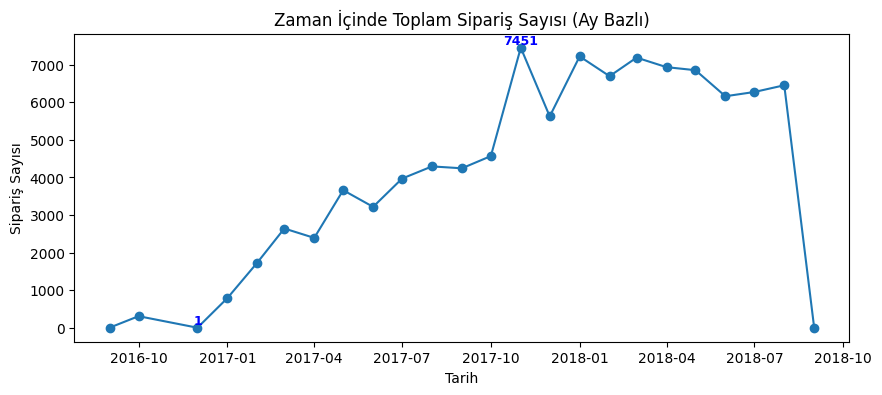

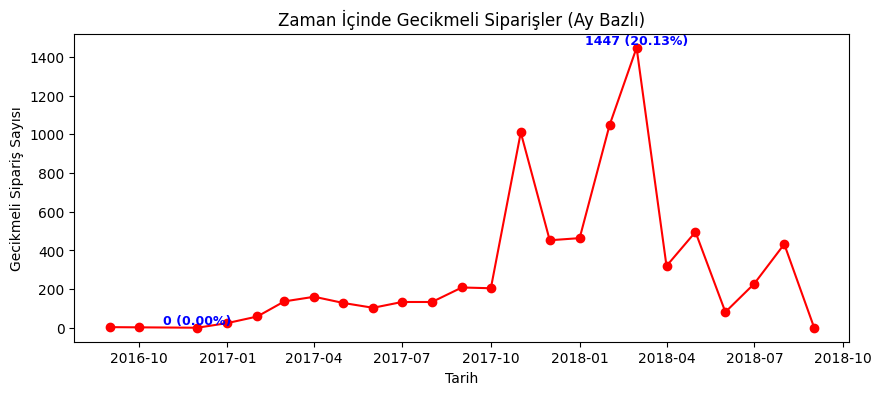

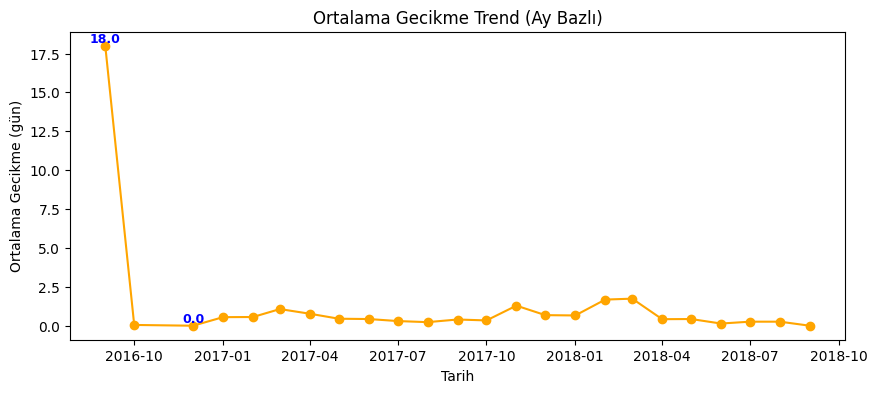

In [87]:

# Yıl / Ay / Hafta kolonlarını çıkar
fact_order_shipments["year"]  = fact_order_shipments["order_purchase_timestamp"].dt.year
fact_order_shipments["month"] = fact_order_shipments["order_purchase_timestamp"].dt.month
fact_order_shipments["week"]  = fact_order_shipments["order_purchase_timestamp"].dt.isocalendar().week
# 3.2 Zaman içinde toplam sipariş sayısı (ay bazlı)
orders_per_month = (
    fact_order_shipments
    .groupby(["year","month"])["order_id_pref"]
    .nunique()
    .reset_index()
)
dates = pd.to_datetime(orders_per_month[["year","month"]].assign(day=1))
values = orders_per_month["order_id_pref"]

plt.figure(figsize=(10,4))
plt.plot(dates, values, marker="o")
# sadece min ve max işaretle
min_idx, max_idx = values.idxmin(), values.idxmax()
for idx in [min_idx, max_idx]:
    plt.text(dates[idx], values[idx], str(values[idx]),
             ha="center", va="bottom", fontsize=9, fontweight="bold", color="blue")
plt.title("Zaman İçinde Toplam Sipariş Sayısı (Ay Bazlı)")
plt.xlabel("Tarih"); plt.ylabel("Sipariş Sayısı")
plt.show()

# 3.3 Zaman içinde gecikmeli sipariş sayısı (ay bazlı + yüzde)
orders_per_month = (
    fact_order_shipments
    .groupby(["year","month"])["order_id_pref"]
    .nunique()
    .reset_index()
    .rename(columns={"order_id_pref":"total_orders"})
)

late_per_month = (
    fact_order_shipments
    .groupby(["year","month"])["is_late"]
    .sum()
    .reset_index()
    .rename(columns={"is_late":"late_orders"})
)

# Join (aynı yıl/ay bazında)
late_ratio = pd.merge(orders_per_month, late_per_month, on=["year","month"])
late_ratio["late_pct"] = (late_ratio["late_orders"] / late_ratio["total_orders"]) * 100

dates = pd.to_datetime(late_ratio[["year","month"]].assign(day=1))
values = late_ratio["late_orders"]

plt.figure(figsize=(10,4))
plt.plot(dates, values, marker="o", color="red")

# sadece min ve max işaretle (adet + %)
min_idx, max_idx = values.idxmin(), values.idxmax()
for idx in [min_idx, max_idx]:
    count = late_ratio.loc[idx, "late_orders"]
    pct   = late_ratio.loc[idx, "late_pct"]
    plt.text(dates[idx], values[idx],
             f"{count} ({pct:.2f}%)",
             ha="center", va="bottom", fontsize=9, fontweight="bold", color="blue")

plt.title("Zaman İçinde Gecikmeli Siparişler (Ay Bazlı)")
plt.xlabel("Tarih"); plt.ylabel("Gecikmeli Sipariş Sayısı")
plt.show()


# 3.4 Ortalama gecikme trendi (ay bazlı)
delay_per_month = (
    fact_order_shipments
    .groupby(["year","month"])["delay_days"]
    .mean()
    .reset_index()
)
dates = pd.to_datetime(delay_per_month[["year","month"]].assign(day=1))
values = delay_per_month["delay_days"].round(2)

plt.figure(figsize=(10,4))
plt.plot(dates, values, marker="o", color="orange")
min_idx, max_idx = values.idxmin(), values.idxmax()
for idx in [min_idx, max_idx]:
    plt.text(dates[idx], values[idx], str(values[idx]),
             ha="center", va="bottom", fontsize=9, fontweight="bold", color="blue")
plt.title("Ortalama Gecikme Trend (Ay Bazlı)")
plt.xlabel("Tarih"); plt.ylabel("Ortalama Gecikme (gün)")
plt.show()


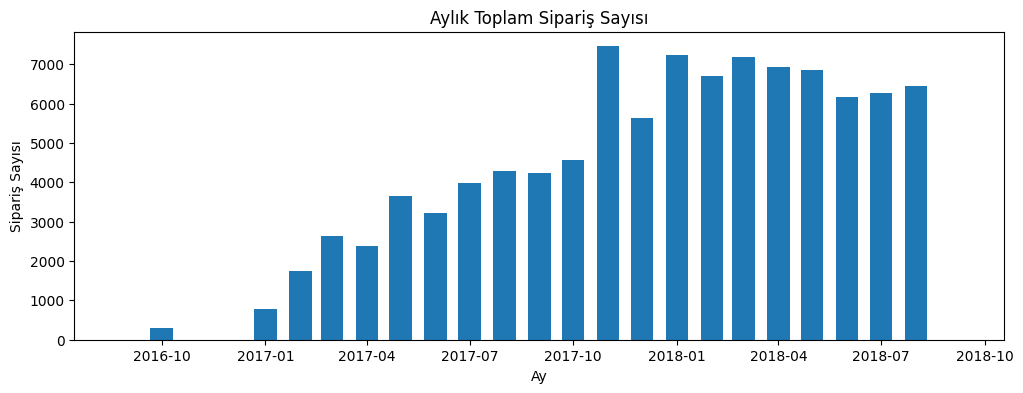

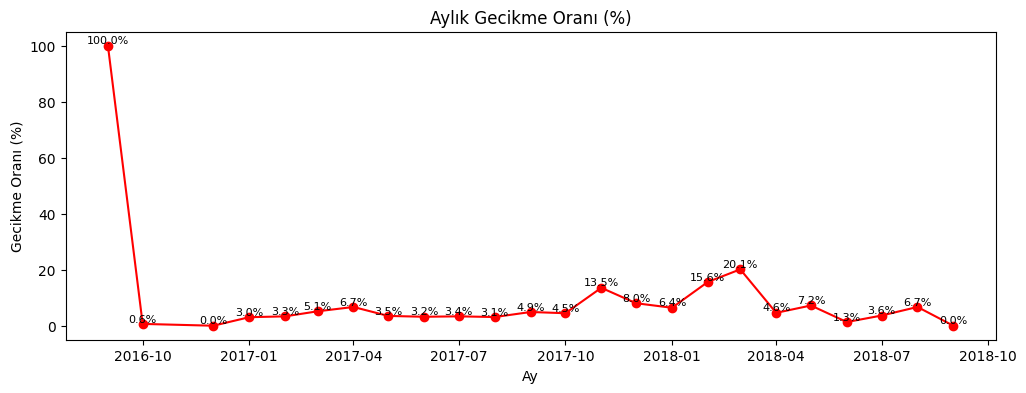

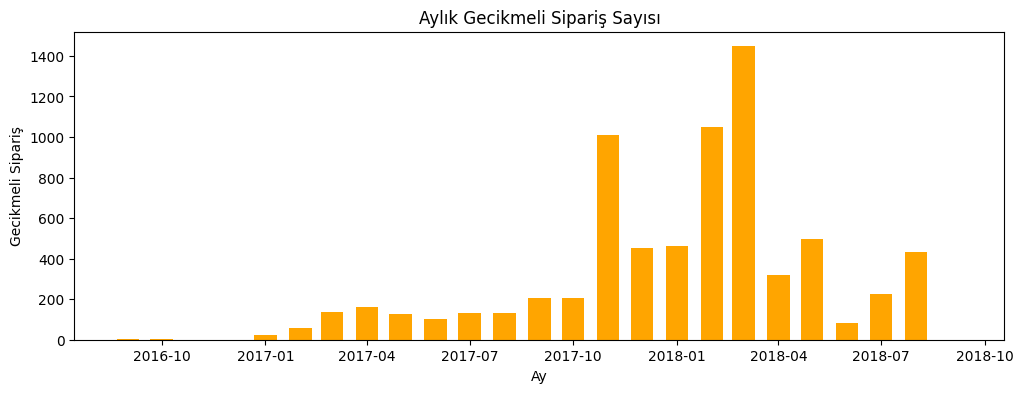

In [88]:

# Aylık toplam ve gecikmeli siparişler
monthly = (
    fact_order_shipments
    .groupby(["year","month"])
    .agg(total_orders=("order_id_pref","nunique"),
         late_orders=("is_late","sum"))
    .reset_index()
)
monthly["late_pct"] = (monthly["late_orders"] / monthly["total_orders"]) * 100
monthly["date"] = pd.to_datetime(monthly[["year","month"]].assign(day=1))

# --- Grafik 1: Aylık toplam siparişler ---
plt.figure(figsize=(12,4))
plt.bar(monthly["date"], monthly["total_orders"], width=20)
plt.title("Aylık Toplam Sipariş Sayısı")
plt.xlabel("Ay"); plt.ylabel("Sipariş Sayısı")
plt.show()

# --- Grafik 2: Aylık gecikme oranı ---
plt.figure(figsize=(12,4))
plt.plot(monthly["date"], monthly["late_pct"], marker="o", color="red")
for x,y in zip(monthly["date"], monthly["late_pct"]):
    plt.text(x, y, f"{y:.1f}%", ha="center", va="bottom", fontsize=8)
plt.title("Aylık Gecikme Oranı (%)")
plt.xlabel("Ay"); plt.ylabel("Gecikme Oranı (%)")
plt.show()

# --- Grafik 3: Aylık gecikmeli sipariş sayısı ---
plt.figure(figsize=(12,4))
plt.bar(monthly["date"], monthly["late_orders"], width=20, color="orange")
plt.title("Aylık Gecikmeli Sipariş Sayısı")
plt.xlabel("Ay"); plt.ylabel("Gecikmeli Sipariş")
plt.show()



## Gecikme Analizi

In [89]:
# Toplam gecikmeli sipariş sayısını hesapla
total_late_orders = fact_order_shipments['is_late'].sum()
print("Toplam gecikmeli sipariş sayısı:", total_late_orders)

Toplam gecikmeli sipariş sayısı: 7265


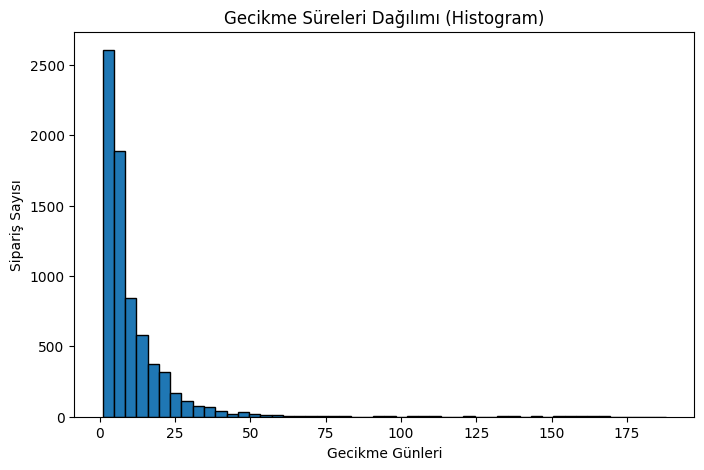

In [90]:
# Sadece gecikmeli siparişler
late_orders = fact_order_shipments[fact_order_shipments['delay_days'] > 0]

plt.figure(figsize=(8,5))
plt.hist(late_orders['delay_days'], bins=50, edgecolor='black')
plt.xlabel("Gecikme Günleri")
plt.ylabel("Sipariş Sayısı")
plt.title("Gecikme Süreleri Dağılımı (Histogram)")
plt.show()

### Gecikme günleri dağılımı – Boxplot

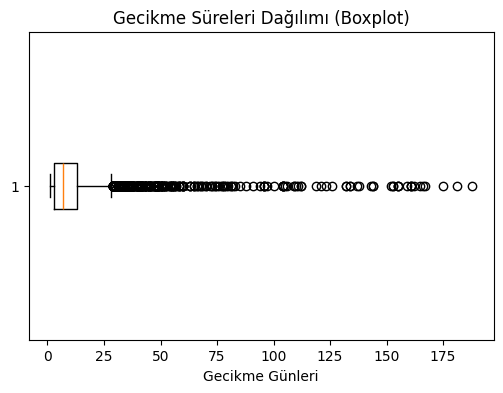

In [91]:
plt.figure(figsize=(6,4))
plt.boxplot(late_orders['delay_days'], vert=False)
plt.xlabel("Gecikme Günleri")
plt.title("Gecikme Süreleri Dağılımı (Boxplot)")
plt.show()

#### Özet istatistikler (ortalama, medyan, min, max)

In [92]:
mean_delay = late_orders['delay_days'].mean()
median_delay = late_orders['delay_days'].median()
min_delay = late_orders['delay_days'].min()
max_delay = late_orders['delay_days'].max()

print("Ortalama gecikme süresi:", mean_delay)
print("Medyan gecikme süresi:", median_delay)
print("Minimum gecikme süresi:", min_delay)
print("Maksimum gecikme süresi:", max_delay)

Ortalama gecikme süresi: 10.488781830695114
Medyan gecikme süresi: 7.0
Minimum gecikme süresi: 1.0
Maksimum gecikme süresi: 188.0


##  Müşteri, Satıcı ve Ürün Bazında Analiz

#### 1. Müşteri başına ortalama gecikme süresi

In [93]:
# Sadece gecikmesi olan siparişleri filtreleyelim
late_orders = fact_order_shipments[fact_order_shipments['delay_days'] > 0]

In [94]:

customer_delay_mean = late_orders.groupby("cusUni")["delay_days"].mean().reset_index()
customer_delay_mean.rename(columns={"delay_days": "avg_delay_days"}, inplace=True)
customer_delay_mean["avg_delay_days"] = customer_delay_mean["avg_delay_days"].astype(int)
customer_delay_mean.head()

,cusUni,avg_delay_days
0,CUSUNI0003,1
1,CUSUNI0019,8
2,CUSUNI0033,37
3,CUSUNI0060,15
4,CUSUNI0090,28


#### 2. Müşteri başına gecikmeli sipariş sayısı

In [95]:
customer_delay_count = late_orders.groupby("cusUni")["order_id_pref"].nunique().reset_index()
customer_delay_count.rename(columns={"order_id_pref": "late_order_count"}, inplace=True)
customer_delay_count.head()

,cusUni,late_order_count
0,CUSUNI0003,1
1,CUSUNI0019,1
2,CUSUNI0033,1
3,CUSUNI0060,1
4,CUSUNI0090,1


#### 3. En yüksek ortalama gecikmeye sahip müşteriler (ilk 10)

In [96]:
top_customers = customer_delay_mean.sort_values("avg_delay_days", ascending=False).head(10)
top_customers

,cusUni,avg_delay_days
4494,CUSUNI68968,188
1385,CUSUNI27483,181
4365,CUSUNI67222,175
3266,CUSUNI51868,167
946,CUSUNI21621,166
2058,CUSUNI3595,165
6047,CUSUNI90158,162
3531,CUSUNI55565,161
4465,CUSUNI68602,161
4328,CUSUNI66759,159


#### 4. Satıcı başına ortalama gecikme süresi

In [97]:
seller_delay_mean = late_orders.groupby("seller_id_pref")["delay_days"].mean().reset_index()
seller_delay_mean.rename(columns={"delay_days": "avg_delay_days"}, inplace=True)
seller_delay_mean.head()

,seller_id_pref,avg_delay_days
0,SEL001,3.000
1,SEL002,1.000
2,SEL005,7.000
3,SEL009,6.500
4,SEL010,17.583


#### 5. Tek satıcılı vs çok satıcılı siparişlerde gecikme karşılaştırması

In [98]:
# Her siparişin kaç farklı satıcı içeriyor:
order_seller_counts = fact_order_shipments.groupby("order_id_pref")["seller_id_pref"].nunique().reset_index()
order_seller_counts.rename(columns={"seller_id_pref": "seller_count"}, inplace=True)

# Gecikme bilgisi ile birlikte:
order_delay = fact_order_shipments.groupby("order_id_pref")["delay_days"].mean().reset_index()
order_seller_delay = order_delay.merge(order_seller_counts, on="order_id_pref")

# Tek satıcılı ve çok satıcılı siparişleri karşılaştırmasi:
comparison = order_seller_delay.groupby("seller_count")["delay_days"].mean().reset_index()
comparison

,seller_count,delay_days
0,1,0.712
1,2,0.044
2,3,0.000
3,4,0.000
4,5,0.000


#### 6. En yüksek ortalama gecikmeye sahip satıcılar (ilk 10)

In [99]:
top_sellers = seller_delay_mean.sort_values("avg_delay_days", ascending=False).head(10)
top_sellers

,seller_id_pref,avg_delay_days
948,SEL2930,167.000
559,SEL2076,159.000
789,SEL2602,134.000
644,SEL2267,132.000
688,SEL2352,132.000
912,SEL2857,100.000
196,SEL1321,97.000
401,SEL1745,91.000
534,SEL2031,80.000
866,SEL2762,76.000


#### 7. Ürün başına ortalama gecikme süresi

In [100]:
product_delay_mean = late_orders.groupby("product_id_pref")["delay_days"].mean().reset_index()
product_delay_mean.rename(columns={"delay_days": "avg_delay_days"}, inplace=True)
product_delay_mean.head()

,product_id_pref,avg_delay_days
0,PRO021,6.000
1,PRO027,7.000
2,PRO032,15.000
3,PRO034,13.000
4,PRO047,7.000


### Missing Values (Eksik Değerler)

In [101]:
# degiskenlerdeki eksik deger sayisi
fact_order_shipments.isnull().sum()

cusUni                              0
customer_order_id                   0
order_id_pref                       0
seller_id_pref                      0
product_id_pref                     0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1194
order_delivered_customer_date    2454
order_estimated_delivery_date       0
prep_time                        1209
shipping_time                    2455
estimated_time                     15
delay_days                          0
delay_class                         0
is_late                             0
distance_km                       554
payment_types                       3
payment_value_sum                   3
payment_installments_max            3
seller_count_per_order              0
year                                0
month                               0
week                                0
dtype: int64

In [102]:
na_cols = utils.table_missing_values(fact_order_shipments, True)

                               n_miss  ratio
shipping_time                    2455  2.180
order_delivered_customer_date    2454  2.180
prep_time                        1209  1.070
order_delivered_carrier_date     1194  1.060
distance_km                       554  0.490
order_approved_at                  15  0.010
estimated_time                     15  0.010
payment_types                       3  0.000
payment_value_sum                   3  0.000
payment_installments_max            3  0.000


In [103]:
utils.missing_VS_target(fact_order_shipments, "is_late", na_cols)

                           TARGET_MEAN   Count
order_approved_at_NA_FLAG                     
0                                0.065  112635
1                                0.000      15


                                      TARGET_MEAN   Count
order_delivered_carrier_date_NA_FLAG                     
0                                           0.065  111456
1                                           0.001    1194


                                       TARGET_MEAN   Count
order_delivered_customer_date_NA_FLAG                     
0                                            0.066  110196
1                                            0.000    2454


                   TARGET_MEAN   Count
prep_time_NA_FLAG                     
0                        0.065  111441
1                        0.001    1209


                       TARGET_MEAN   Count
shipping_time_NA_FLAG                     
0                            0.066  110195
1                            0.000    2455


      

In [104]:
# Eksik değerler için NA_FLAG sütunlarını ekleyip, median veya mode ile doldur
def handle_missing_values(df):
    df_clean = df.copy()
    
    # Sayısal kolonlar için flag + category-based median
    num_cols_flag = ['shipping_time', 'prep_time', 'distance_km', 'order_approved_at', 'estimated_time']
    for col in num_cols_flag:
        na_flag_col = col + "_NA_FLAG"
        df_clean[na_flag_col] = df_clean[col].isnull().astype(int)
        df_clean[col] = df_clean.groupby('month')[col].transform(lambda x: x.fillna(x.median()))
    
    # Çok az eksik kolonlar -> mode ile doldurma
    cols_few_na = ['payment_types', 'payment_value_sum', 'payment_installments_max']
    for col in cols_few_na:
        df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])
    
    return df_clean


In [105]:
fact_order_clean = handle_missing_values(fact_order_shipments)
print(f"Orijinal satır sayısı: {fact_order_shipments.shape[0]}")
print(f"Temizlenmiş satır sayısı: {fact_order_clean.shape[0]}")

Orijinal satır sayısı: 112650
Temizlenmiş satır sayısı: 112650


In [106]:
# Mevcut kolon UInt32Dtype ise önce .to_numpy() ile numpy array’e çevir
fact_order_clean['week'] = fact_order_clean['week'].to_numpy(dtype='int32')

In [107]:
fact_order_clean.dtypes['week']

dtype('int32')

In [108]:
# Tüm süre kolonları için negatif değerleri 0 ile değiştir
time_cols = ["prep_time", "shipping_time", "estimated_time"]

for col in time_cols:
    fact_order_clean[col] = fact_order_clean[col].clip(lower=0)

# Temizlik sonrası kontrol
for col in time_cols:
    print(f"=== {col} ===")
    print("Min value:", fact_order_clean[col].min())
    print("Negative values count:", (fact_order_clean[col] < 0).sum())
    print("Missing values:", fact_order_clean[col].isnull().sum())

=== prep_time ===
Min value: 0.0
Negative values count: 0
Missing values: 0
=== shipping_time ===
Min value: 0.0
Negative values count: 0
Missing values: 0
=== estimated_time ===
Min value: 0.0
Negative values count: 0
Missing values: 0


#############################################
### 1. Outliers (Aykırı Değerler)
#############################################

In [109]:
## Outlier Analizi

In [110]:
fact_order_clean.head()

,cusUni,customer_order_id,order_id_pref,seller_id_pref,product_id_pref,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,prep_time,shipping_time,estimated_time,delay_days,delay_class,is_late,distance_km,payment_types,payment_value_sum,payment_installments_max,seller_count_per_order,year,month,week,shipping_time_NA_FLAG,prep_time_NA_FLAG,distance_km_NA_FLAG,order_approved_at_NA_FLAG,estimated_time_NA_FLAG
0,CUSUNI64073,CUS65558,ORD85268,SEL514,PRO25866,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,6.000,1.000,15.000,0.000,0,0,301.505,credit_card,72.190,2.000,1,2017,9,37,0,0,0,0,0
1,CUSUNI33838,CUS34266,ORD71854,SEL472,PRO27231,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,8.000,8.000,18.000,0.000,0,0,585.565,credit_card,259.830,3.000,1,2017,4,17,0,0,0,0,0
2,CUSUNI34511,CUS34956,ORD6299,SEL1825,PRO22625,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,1.000,6.000,21.000,0.000,0,0,312.344,credit_card,216.870,5.000,1,2018,1,2,0,0,0,0,0
3,CUSUNI50803,CUS51764,ORD22551,SEL2024,PRO15404,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,2.000,4.000,11.000,0.000,0,0,293.169,credit_card,25.780,2.000,1,2018,8,32,0,0,0,0,0
4,CUSUNI7582,CUS7603,ORD5248,SEL1598,PRO8863,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,11.000,13.000,40.000,0.000,0,0,646.164,credit_card,218.040,3.000,1,2017,2,5,0,0,0,0,0


### LOF Modeli ile çok değişkenli aykırı değer tespiti

In [111]:
# Outlier kontrolü yapmak istediğimiz kolonlar
num_cols_for_lof = [
    'prep_time', 'shipping_time', 'estimated_time', 
    'distance_km', 'payment_value_sum', 'payment_installments_max'
]

In [112]:
utils.check_outliers_for_columns(fact_order_shipments, num_cols_for_lof)

D:\EuroTech_DataScience\Proje\utils.py:140: FutureWarning: 'any' with datetime64 dtypes is deprecated and will raise in a future version. Use (obj != pd.Timestamp(0)).any() instead.
  if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
D:\EuroTech_DataScience\Proje\utils.py:140: FutureWarning: 'any' with datetime64 dtypes is deprecated and will raise in a future version. Use (obj != pd.Timestamp(0)).any() instead.
  if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
D:\EuroTech_DataScience\Proje\utils.py:140: FutureWarning: 'any' with datetime64 dtypes is deprecated and will raise in a future version. Use (obj != pd.Timestamp(0)).any() instead.
  if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
D:\EuroTech_DataScience\Proje\utils.py:140: FutureWarning: 'any' with datetime64 dtypes is deprecated and will raise in a future version. Use (obj != p

{'prep_time': True,
 'shipping_time': True,
 'estimated_time': True,
 'distance_km': True,
 'payment_value_sum': True,
 'payment_installments_max': True}

In [113]:
# LOF ile aykırı değerleri tespit et
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)  # %5 uç değerler
lof_labels = lof.fit_predict(fact_order_clean[num_cols_for_lof])
lof_scores = lof.negative_outlier_factor_
print("\nİlk 5 LOF skoru:", lof_scores[0:5])


İlk 5 LOF skoru: [-1.15039259 -1.00906886 -0.97990961 -1.13694982 -1.21023077]


C:\Users\onayk\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


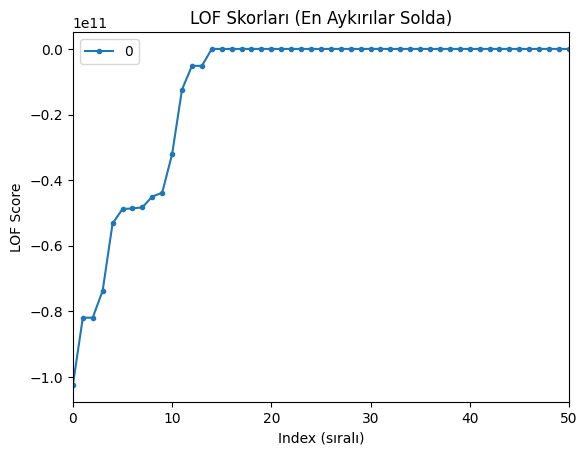

In [114]:
# Eşik değer görselleştirme
# ----------------------------
scores = pd.DataFrame(np.sort(lof_scores))
scores.plot(stacked=True, xlim=[0, 50], style='.-')
plt.xlabel("Index (sıralı)")
plt.ylabel("LOF Score")
plt.title("LOF Skorları (En Aykırılar Solda)")
plt.show()

In [115]:
# Aykırı gözlemleri seç
outliers_index = fact_order_clean[num_cols_for_lof].index[lof_labels == -1]
print("Aykırı satır sayısı:", len(outliers_index))

Aykırı satır sayısı: 5633


In [116]:
# Aykırı değerleri alt-üst limit yöntemiyle eşitle (clip yerine fonksiyon kullanabilirsin)
for col in num_cols_for_lof:
    utils.replace_with_thresholds(fact_order_clean, col)
    print("Aykırı değerler alt-üst limitlere eşitlendi.")

Aykırı değerler alt-üst limitlere eşitlendi.
Aykırı değerler alt-üst limitlere eşitlendi.
Aykırı değerler alt-üst limitlere eşitlendi.
Aykırı değerler alt-üst limitlere eşitlendi.
Aykırı değerler alt-üst limitlere eşitlendi.
Aykırı değerler alt-üst limitlere eşitlendi.


In [117]:
utils.check_outliers_for_columns(fact_order_clean, num_cols_for_lof)

D:\EuroTech_DataScience\Proje\utils.py:140: FutureWarning: 'any' with datetime64 dtypes is deprecated and will raise in a future version. Use (obj != pd.Timestamp(0)).any() instead.
  if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
D:\EuroTech_DataScience\Proje\utils.py:140: FutureWarning: 'any' with datetime64 dtypes is deprecated and will raise in a future version. Use (obj != pd.Timestamp(0)).any() instead.
  if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
D:\EuroTech_DataScience\Proje\utils.py:140: FutureWarning: 'any' with datetime64 dtypes is deprecated and will raise in a future version. Use (obj != pd.Timestamp(0)).any() instead.
  if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
D:\EuroTech_DataScience\Proje\utils.py:140: FutureWarning: 'any' with datetime64 dtypes is deprecated and will raise in a future version. Use (obj != p

{'prep_time': False,
 'shipping_time': False,
 'estimated_time': False,
 'distance_km': False,
 'payment_value_sum': False,
 'payment_installments_max': False}


=== prep_time ===
Original describe:
count   111441.000
mean         2.348
std          3.600
min       -172.000
25%          0.000
50%          1.000
75%          3.000
max        125.000
Name: prep_time, dtype: float64
Cleaned describe:
count   112650.000
mean         2.052
std          2.179
min          0.000
25%          0.000
50%          1.000
75%          3.000
max          7.500
Name: prep_time, dtype: float64
Negative values after cleaning: 0
Missing values: 0


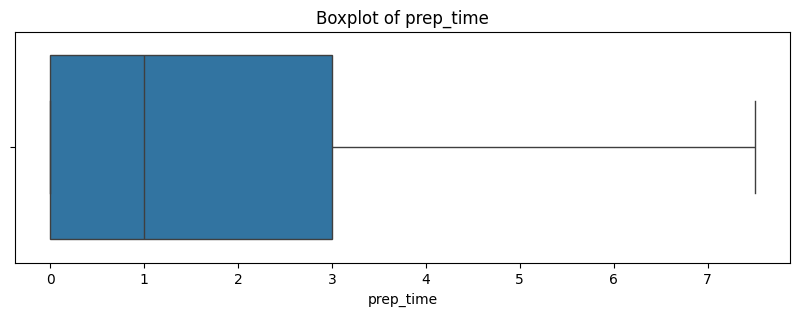

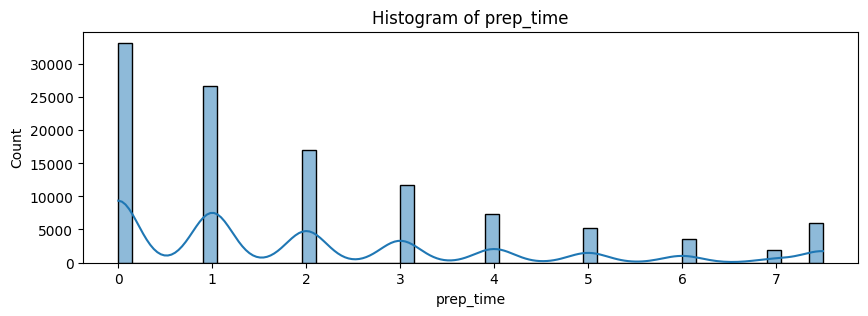


=== shipping_time ===
Original describe:
count   110195.000
mean         8.734
std          8.612
min        -17.000
25%          4.000
50%          7.000
75%         11.000
max        205.000
Name: shipping_time, dtype: float64
Cleaned describe:
count   112650.000
mean         8.042
std          5.852
min          0.000
25%          4.000
50%          7.000
75%         11.000
max         21.500
Name: shipping_time, dtype: float64
Negative values after cleaning: 0
Missing values: 0


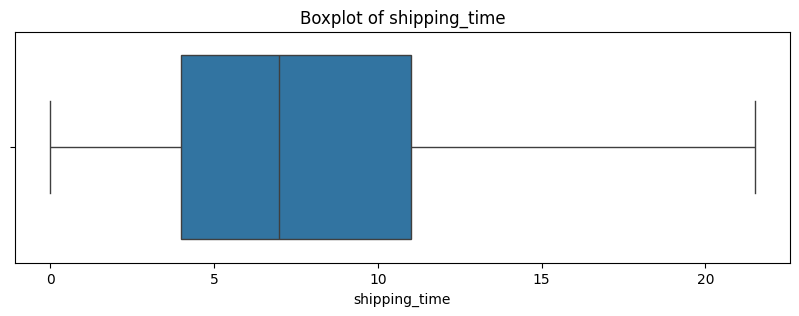

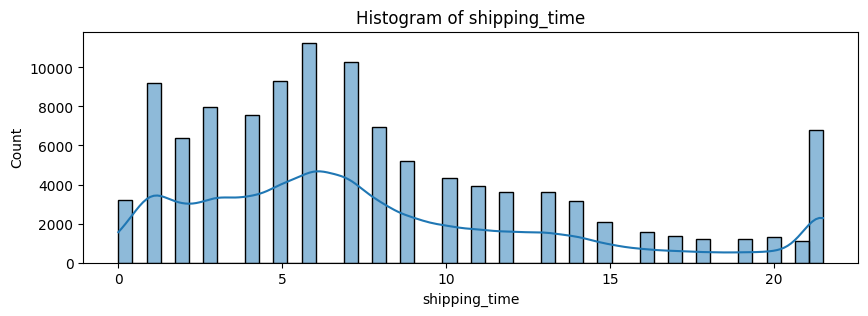


=== estimated_time ===
Original describe:
count   112635.000
mean        22.942
std          8.901
min         -7.000
25%         18.000
50%         22.000
75%         28.000
max        153.000
Name: estimated_time, dtype: float64
Cleaned describe:
count   112650.000
mean        22.756
std          8.222
min          3.000
25%         18.000
50%         22.000
75%         28.000
max         43.000
Name: estimated_time, dtype: float64
Negative values after cleaning: 0
Missing values: 0


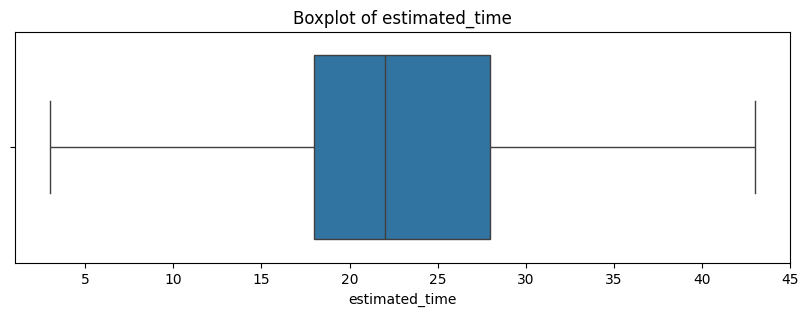

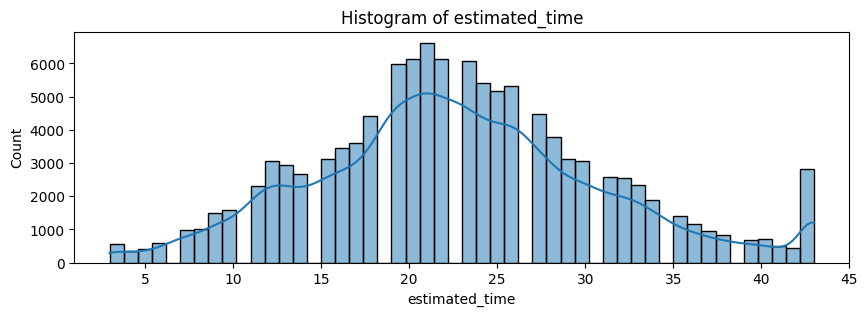


=== distance_km ===
Original describe:
count   112096.000
mean       596.960
std        589.980
min          0.000
25%        184.066
50%        431.636
75%        792.277
max       8677.924
Name: distance_km, dtype: float64
Cleaned describe:
count   112650.000
mean       557.094
std        482.069
min          0.000
25%        187.578
50%        431.259
75%        789.009
max       1691.156
Name: distance_km, dtype: float64
Negative values after cleaning: 0
Missing values: 0


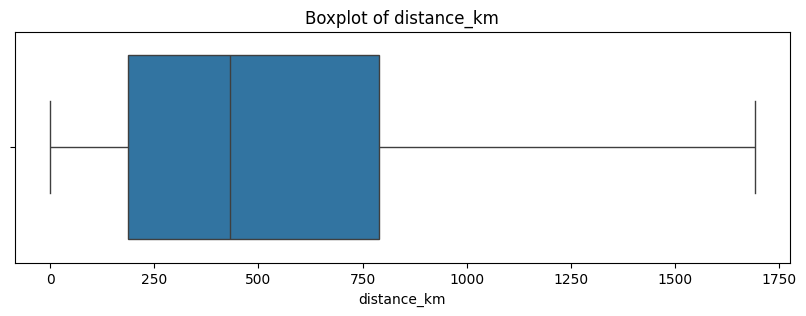

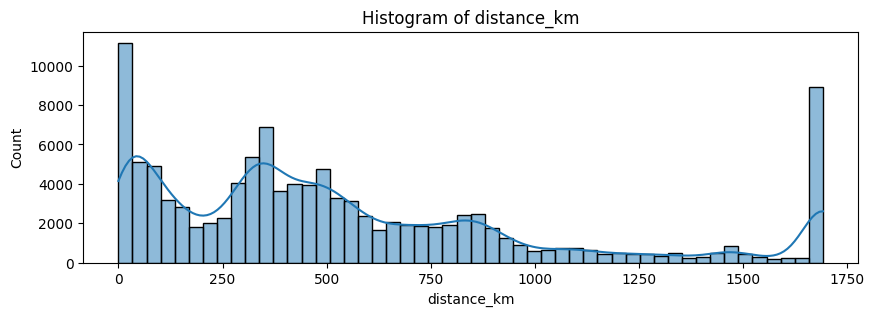


=== payment_value_sum ===
Original describe:
count   112647.000
mean       180.281
std        272.849
min          9.590
25%         65.670
50%        114.440
75%        195.390
max      13664.080
Name: payment_value_sum, dtype: float64
Cleaned describe:
count   112650.000
mean       147.462
std        106.599
min          9.590
25%         65.670
50%        114.440
75%        195.382
max        389.951
Name: payment_value_sum, dtype: float64
Negative values after cleaning: 0
Missing values: 0


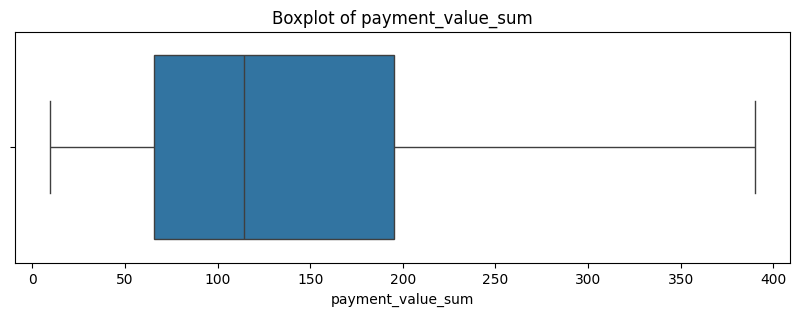

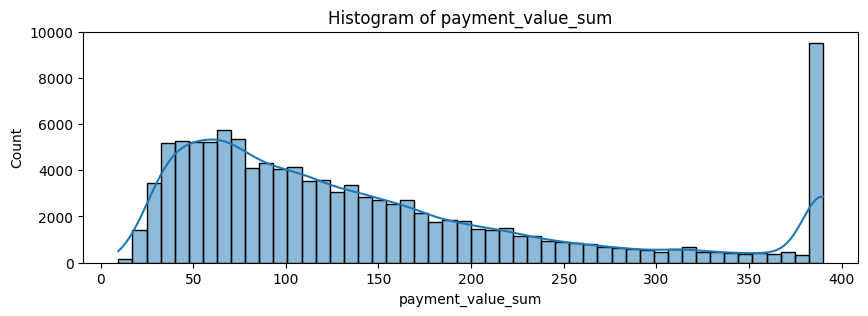


=== payment_installments_max ===
Original describe:
count   112647.000
mean         3.018
std          2.803
min          0.000
25%          1.000
50%          2.000
75%          4.000
max         24.000
Name: payment_installments_max, dtype: float64
Cleaned describe:
count   112650.000
mean         2.900
std          2.489
min          0.000
25%          1.000
50%          2.000
75%          4.000
max          8.500
Name: payment_installments_max, dtype: float64
Negative values after cleaning: 0
Missing values: 0


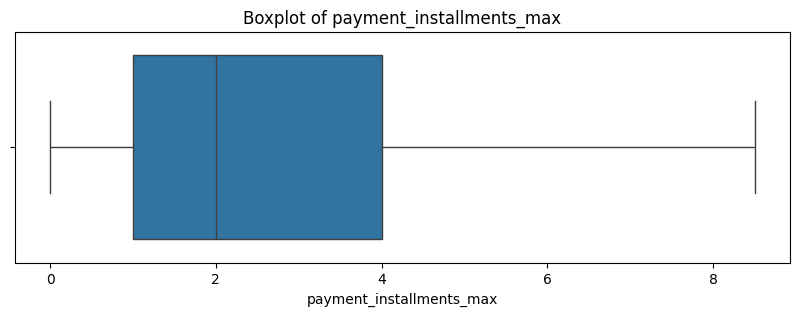

In [ ]:
utils.check_outlier_cleaning(fact_order_shipments, fact_order_clean, num_cols_for_lof)

## Veri Temizleme ve Aykırı Değer İşlemleri

Bu adımda, modelleme öncesi veri setinin kalitesini artırmak için eksik değerlerin ve aykırı değerlerin temizlenmesi, sayısal değişkenlerin mantıksal sınırlar içinde tutulması gibi işlemler yapıldı. İşlemler aşağıdaki şekilde gerçekleştirildi:

#### 1. Eksik Değerlerin İşlenmesi

Neden:
Eksik değerler modelin doğruluğunu düşürebilir veya algoritmaların çalışmasını engelleyebilir. Bazı algoritmalar (ör. LocalOutlierFactor) eksik değerleri işleyemez.

Nasıl:

Her kolon için eksik değerler sayıldı ve yüzdesi hesaplandı.

Eksik değer oranı çok düşük olan satırlar silindi veya eksik değerler uygun bir şekilde işaretlendi (NA_FLAG).

Örnek: prep_time, shipping_time, distance_km gibi kolonlarda eksik değerler temizlendi.

Sonuç:

Tüm eksik değerler işlendikten sonra veri setinde eksik değer kalmadı.

Temizleme sonrası satır sayısı orijinal veri setine çok yakın kaldı, veri kaybı minimum düzeyde oldu.

#### 2. Mantıksal Alt ve Üst Limitlerin Uygulanması

Neden:
Bazı değişkenlerde negatif değerler veya mantıksal olarak mümkün olmayan değerler bulunabiliyordu (ör. prep_time negatif olamaz). Bu tür değerler modelin yanlış öğrenmesine neden olabilir.

Nasıl:

prep_time, shipping_time, estimated_time gibi sayısal değişkenler için alt limit 0 olarak belirlendi.

Negatif değerler bu alt limite eşitlendi.

Sonuç:

Temizlik sonrası bu kolonlarda negatif değer kalmadı.

Mantıksal olarak geçerli veri aralıkları sağlanmış oldu.

#### 3. Aykırı Değerlerin Tespiti ve İşlenmesi

Neden:
Aykırı değerler modelin performansını bozabilir, istatistiksel özetleri yanıltabilir ve bazı algoritmaların sonuçlarını dengesizleştirebilir.

Nasıl:

Sayısal değişkenler için Local Outlier Factor (LOF) yöntemi ile uç değerler tespit edildi.

Tespit edilen uç değerler, IQR yöntemi ile belirlenen alt ve üst eşiklere (Q1 - 1.5*IQR, Q3 + 1.5*IQR) göre sınırlandırıldı.

Böylece aşırı uç değerler veri setine zarar vermeden normalize edildi.

Sonuç:

Örnek: prep_time değişkenindeki maksimum değer 125’ten 7.5’e düşürüldü.


shipping_time, estimated_time, distance_km, payment_value_sum gibi değişkenlerde mantıksal sınırlar sağlandı.

Temizleme sonrası veri seti modelleme için daha güvenli ve dengeli hale geldi.


Bu işlemler tamamlandıktan sonra veri seti:

Eksik değerlerden arındırıldı,

Mantıksal olarak geçerli aralıklara getirildi,

Aykırı değerlerin etkisi minimize edildi.

Artık veri seti, özellik mühendisliği, encoding ve modelleme adımlarına hazırdır.